# Codigo para testar o modelo em diferentes trajetórias (Até agora não deu bom)

# Import 0

In [6]:
import pandas as pd
import glob
import time 
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation
import matplotlib.colors as mcolors
import statistics
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
from PIL import Image
import random


def read_generic(name, n_states):
    """
    Leitura genérica de CSV tab-delimitado contendo pares (estado, derivada) e em seguida seus objetivos.
    name     : caminho para o arquivo
    n_states : número de variáveis de estado (ex: 2 para 1D, 4 para 2D)
    Retorna dict com:
      - 'states': array shape (n_states, N)
      - 'goals' : array shape (n_states, N)
      - 't'     : vetor tempo shape (N,)
      - 'trial' : vetor trial shape (N,)
    """
    states, goals, t_list, trials = [], [], [], []
    with open(name, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)  # pula header
        for row in reader:
            vals = list(map(float, row[0].split()))
            # primeiros n_states são os estados reais, próximos n_states são os objetivos
            s = np.array(vals[0:   n_states])
            g = np.array(vals[n_states:2*n_states])
            states.append(s)
            goals.append(g)
            t_list.append(float(row[1]))
            trials.append(float(row[2]))

    return {
        'states': np.vstack(states).T,
        'goals' : np.vstack(goals).T,
        't'     : np.array(t_list),
        'trial' : np.array(trials)
    }


def create_generic_series(Title, Subtitles, all_data, state_labels, t_lim=None):
    """
    Gráfico genérico de séries temporais para N estados.
    Title        : título geral
    Subtitles    : lista de legendas (uma por experimento)
    all_data     : lista de dicts retornados por read_generic
    state_labels : nomes das variáveis de estado
    t_lim        : limite de tempo em xlim
    """
    n = len(state_labels)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(10, 5 * n))

    # 1) plota o degrau (goal) primeiro, para que fique em primeiro na legenda
    for i, name in enumerate(state_labels):
        axes[i].plot(all_data[0]['t'],
                     all_data[0]['goals'][i],
                     '--',
                     label=f"{name}_goal")
    # 2) agora plota as séries de dados
    for data, label in zip(all_data, Subtitles):
        for i, name in enumerate(state_labels):
            axes[i].plot(data['t'], data['states'][i], label=label)

    for i, name in enumerate(state_labels):
        axes[i].set_ylabel(name)
        if t_lim is not None:
            axes[i].set_xlim(0, t_lim)

    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(Title)
    axes[0].legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# -------------------- Wrappers para retrocompatibilidade --------------------

def read_one(name):
    # Leitura 1D (posição e velocidade)
    # O CSV contém 4 variáveis (x, x_dot, y, y_dot) + seus objetivos,
    # mas aqui só extraímos os dois primeiros estados
    data = read_generic(name, n_states=4)
    # retornamos só x e x_dot (estados e metas)
    return {
        'states': data['states'][:2],
        'goals' : data['goals'][:2],
        't'     : data['t'],
        'trial' : data['trial']
    }


def Create_1D_Graphic(Title, Subtitles, Data):
    state_labels = ["x", "x_dot"]
    create_generic_series(Title, Subtitles, Data, state_labels, t_lim=5)


def Create_1D_Graphic2(Title, Subtitles, Data, t):
    state_labels = ["x", "x_dot"]
    create_generic_series(Title, Subtitles, Data, state_labels, t_lim=t)


def read_one_2D(name):
    # Leitura 2D (x, x_dot, y, y_dot)
    return read_generic(name, n_states=4)


def Create_2D_Graphic(Title, Data, t_lim=None):
    """
    Mantém layout espacial + de séries em X/Y, mas usando data dict.
    Title : título geral
    Data  : lista de dicts
    t_lim : limite de tempo nos eixos X/Y
    """
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 2, 1])

    X  = plt.subplot(gs[0, 0]); X.set_title("Position X")
    XY = plt.subplot(gs[:, 1]);  XY.set_title("Position 2D")
    Y  = plt.subplot(gs[0, 2]); Y.set_title("Position Y")
    XD = plt.subplot(gs[1, 0]); XD.set_title("Velocity X")
    YD = plt.subplot(gs[1, 2]); YD.set_title("Velocity Y")

    # referência
    goal = Data[0]['goals']
    tvec = Data[0]['t']
    X.plot(tvec, goal[0], '--', label='x_goal')
    Y.plot(tvec, goal[2], '--', label='y_goal')
    XY.plot(goal[0], goal[2], 'o', label='goal')
    XD.plot(tvec, goal[1], '--', label='x_dot_goal')
    YD.plot(tvec, goal[3], '--', label='y_dot_goal')

    # dados reais
    for idx, D in enumerate(Data):
        lbl = f"Run {idx}"
        X.plot(D['t'], D['states'][0], label=lbl)
        Y.plot(D['t'], D['states'][2], label=lbl)
        XY.plot(D['states'][0], D['states'][2], label=lbl)
        XD.plot(D['t'], D['states'][1], label=lbl)
        YD.plot(D['t'], D['states'][3], label=lbl)

    # ajustes de limites e rótulos
    for ax in [X, XD, Y, YD]:
        if t_lim is not None:
            ax.set_xlim(0, t_lim)
        ax.set_xlabel("[s]")
    X.set_ylabel("[m]")
    XD.set_ylabel("[m/s]")
    Y.set_ylabel("[m]")
    YD.set_ylabel("[m/s]")

    XY.set_xlabel("X [m]")
    XY.set_ylabel("Y [m]")
    XY.set_xlim(-4, 4)
    XY.set_ylim(-4, 4)

    X.legend(loc='upper right')
    fig.suptitle(Title, fontsize=20)
    plt.tight_layout()
    plt.show()


# Import (1)

In [2]:
#Teste com o codigo de AnalisisCoef
import pandas as pd
import glob
import time
import csv
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation
import matplotlib.colors as mcolors
import statistics
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
from PIL import Image
import random

def read_generic(name, n_states):
    """
    Leitura genérica de CSV em dois formatos:
    
    1) CSV de trials (tab-delimitado, coluna 0 = "s0,...,sN,g0,...,gN", col1=Time, col2=Trial)
    2) CSV de média (_avg.csv gerado por pandas): colunas separadas Time, State0…StateN-1,
       opcionalmente Goal0…GoalN-1, Trial
    
    Retorna dict com
      'states': (n_states, N),  'goals': (n_states, N),
      't': (N,),  'trial': (N,)
    """
    # — caso _avg.csv —
    if name.endswith('_avg.csv'):
        df = pd.read_csv(name)
        state_cols = [f"State{i}" for i in range(n_states)]
        states = df[state_cols].values.T
        
        goal_cols = [f"Goal{i}" for i in range(n_states)]
        if all(col in df.columns for col in goal_cols):
            goals = df[goal_cols].values.T
        else:
            # sem coluna de meta → posição = 1.0, demais estados = 0.0
            goals = np.zeros_like(states)
            goals[0, :] = 1.0
        
        t     = df["Time"].values
        trial = df["Trial"].values if "Trial" in df.columns else np.zeros_like(t, dtype=int)
        
        return {"states": states, "goals": goals, "t": t, "trial": trial}

    # — caso CSV original de trials —
    states, goals, t_list, trials = [], [], [], []
    with open(name, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        next(reader)
        for row in reader:
            if not row or len(row) < 3:
                continue
            parts = re.split(r"[,\s\t]+", row[0].strip())
            vals  = [float(x) for x in parts if x]
            s = np.array(vals[0:   n_states])
            g = np.array(vals[n_states:2*n_states])
            states.append(s)
            goals.append(g)
            t_list.append(float(row[1]))
            trials.append(int(float(row[2])))

    if not states:
        raise ValueError(f"Não consegui ler dados em '{name}'")

    return {
        "states": np.vstack(states).T,
        "goals" : np.vstack(goals).T,
        "t"     : np.array(t_list),
        "trial" : np.array(trials, dtype=int)
    }

def create_generic_series(Title, Subtitles, all_data, state_labels, t_lim=None):
    """
    Gráfico genérico de séries temporais para N estados, ignorando o integrador
    na hora de desenhar o goal.
    Title        : título geral
    Subtitles    : lista de legendas (uma por experimento)
    all_data     : lista de dicts retornados por read_generic (n_states = len(state_labels)+1)
    state_labels : nomes das variáveis de estado (excluir 'integrator')
    t_lim        : limite de tempo em xlim
    """
    # número de variáveis físicas (exclui integrador)
    n = len(state_labels)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(10, 5 * n))

    # 1) plota apenas as metas dos estados físicos, não do integrador
    for i, name in enumerate(state_labels):
        axes[i].plot(
            all_data[0]['t'],
            all_data[0]['goals'][i],  # só 0..n-1, sem o integrador
            '--', label=f"{name}_goal"
        )

    # 2) plota as séries de dados (que já vêm em states[0..n-1])
    for data, label in zip(all_data, Subtitles):
        for i, name in enumerate(state_labels):
            axes[i].plot(data['t'], data['states'][i], label=label)

    # formatação final
    for i, name in enumerate(state_labels):
        axes[i].set_ylabel(name)
        if t_lim is not None:
            axes[i].set_xlim(0, t_lim)

    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(Title)
    axes[0].legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# — Wrappers para retrocompatibilidade —

def read_one(name):
    # Leitura 1D (posição e velocidade)
    data = read_generic(name, n_states=5)
    return {
        'states': data['states'][:2],
        'goals' : data['goals'][:2],
        't'     : data['t'],
        'trial' : data['trial']
    }

def Create_1D_Graphic(Title, Subtitles, Data):
    """
    Dois painéis: posição (topo) e velocidade (baixo). 
    Alvos em t=1+tr_target, y=1*(1+Mp_target/100), t=1+Ts_target no 
    painel de posição, e legenda à direita.
    """

    # — parâmetros de controle —
    tr_target = 1.5   # rise time desejado (s após t=1)
    Mp_target = 5.0   # overshoot desejado (%)
    Ts_target = 2.0   # settling time desejado (s após t=1)
    # ——————————————

    fig, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(Title, fontsize=14)

    t = Data[0]['t']
    step = np.where(t >= 1.0, 1.0, 0.0)

    # desenha step
    ax_pos.plot(t, step, 'k--', label="Goal (step)")
    ax_vel.plot(t, np.zeros_like(t), 'k--', label="_nolegend_")

    # desenha alvos fixos
    ax_pos.axvline(1 + tr_target, color='r', linestyle='--', label=f"Tr target={tr_target}s")
    ax_pos.axhline(1*(1+Mp_target/100), color='m', linestyle=':', label=f"Mp target={Mp_target}%")
    ax_pos.axvline(1 + Ts_target, color='c', linestyle='-.', label=f"Ts target={Ts_target}s")

    # plota cada curva
    for i, (label, D) in enumerate(zip(Subtitles, Data)):
        c = f"C{i}"
        ax_pos.plot(D['t'], D['states'][0], color=c, label=label)
        ax_vel.plot(D['t'], D['states'][1], color=c)

    # —— aqui as linhas que garantem o box até 5s ——
    ax_pos.set_xlim(0, 5)
    ax_vel.set_xlim(0, 5)

    ax_pos.set_ylabel("Position [m]")
    ax_vel.set_ylabel("Velocity [m/s]")
    ax_vel.set_xlabel("Time [s]")

    # legenda única no topo, à direita
    ax_pos.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.show()

def Create_1D_Graphic2(Title, Subtitles, Data, t):
    create_generic_series(Title, Subtitles, Data, ["x", "x_dot"], t)

def read_one_2D(name):
    return read_generic(name, n_states=4)

def Create_2D_Graphic(Title, Data, t_lim=None):
    """
    Mantém layout espacial + de séries em X/Y, mas usando data dict.
    """
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 2, 1])

    X  = plt.subplot(gs[0, 0]); X.set_title("Position X")
    XY = plt.subplot(gs[:, 1]);  XY.set_title("Position 2D")
    Y  = plt.subplot(gs[0, 2]); Y.set_title("Position Y")
    XD = plt.subplot(gs[1, 0]); XD.set_title("Velocity X")
    YD = plt.subplot(gs[1, 2]); YD.set_title("Velocity Y")

    goal = Data[0]['goals']
    tvec = Data[0]['t']
    X.plot(tvec, goal[0], '--', label='x_goal')
    Y.plot(tvec, goal[2], '--', label='y_goal')
    XY.plot(goal[0], goal[2], 'o', label='goal')
    XD.plot(tvec, goal[1], '--', label='x_dot_goal')
    YD.plot(tvec, goal[3], '--', label='y_dot_goal')

    for idx, D in enumerate(Data):
        lbl = f"Run {idx}"
        X.plot(D['t'], D['states'][0], label=lbl)
        Y.plot(D['t'], D['states'][2], label=lbl)
        XY.plot(D['states'][0], D['states'][2], label=lbl)
        XD.plot(D['t'], D['states'][1], label=lbl)
        YD.plot(D['t'], D['states'][3], label=lbl)

    for ax in [X, XD, Y, YD]:
        if t_lim is not None:
            ax.set_xlim(0, t_lim)
        ax.set_xlabel("[s]")
    X.set_ylabel("[m]")
    XD.set_ylabel("[m/s]")
    Y.set_ylabel("[m]")
    YD.set_ylabel("[m/s]")

    XY.set_xlabel("X [m]")
    XY.set_ylabel("Y [m]")
    XY.set_xlim(-4, 4)
    XY.set_ylim(-4, 4)

    X.legend(loc='upper right')
    fig.suptitle(Title, fontsize=20)
    plt.tight_layout()
    plt.show()


def Create_Load_Graphic(Title, Subtitles, Data, t_lim=None):
    """
    Quatro painéis empilhados:
      1) posição x vs tempo
      2) velocidade x_dot vs tempo
      3) posição angular θ vs tempo
      4) velocidade angular θ_dot vs tempo

    Title     : título geral
    Subtitles : lista de legendas (uma por experimento)
    Data      : lista de dicts com 'states', 'goals', 't', 'trial'
                states.shape = (n_states, N), aqui n_states >= 4
    t_lim     : (opcional) limite de tempo em xlim
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # abre figura com 4 linhas
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 10))
    ax_x, ax_xd, ax_th, ax_thd = axes
    fig.suptitle(Title, fontsize=16)

    t    = Data[0]['t']
    goal = Data[0]['goals']  # shape ≥ (4, N)

    # 1) posição x
    ax_x.plot(t, goal[0], '--', color='C0', label='x_goal')
    # 2) velocidade x_dot
    ax_xd.plot(t, goal[1], '--', color='C0', label='ẋ_goal')
    # 3) posição angular θ
    ax_th.plot(t, goal[2], '--', color='C2', label='θ_goal')
    # 4) velocidade angular θ_dot
    ax_thd.plot(t, goal[3], '--', color='C2', label='θ̇_goal')

    # para cada trial, plota as curvas
    for i, (label, D) in enumerate(zip(Subtitles, Data)):
        c = f"C{i+1}"
        ax_x.plot( D['t'], D['states'][0], color=c, alpha=0.8, label=label)
        ax_xd.plot(D['t'], D['states'][1], color=c, alpha=0.8)
        ax_th.plot(D['t'], D['states'][2], color=c, alpha=0.8)
        ax_thd.plot(D['t'], D['states'][3], color=c, alpha=0.8)

    # legendas
    ax_x .legend(loc='upper right', ncol=2)
    ax_th.legend(loc='upper right', ncol=2)

    # labels e limites
    ax_x .set_ylabel("Position [m]")
    ax_xd.set_ylabel("Velocity [m/s]")
    ax_th.set_ylabel("θ [rad]")
    ax_thd.set_ylabel("θ̇ [rad/s]")
    ax_thd.set_xlabel("Time [s]")

    if t_lim is not None:
        for ax in axes:
            ax.set_xlim(0, t_lim)

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Analise do Step Unitario

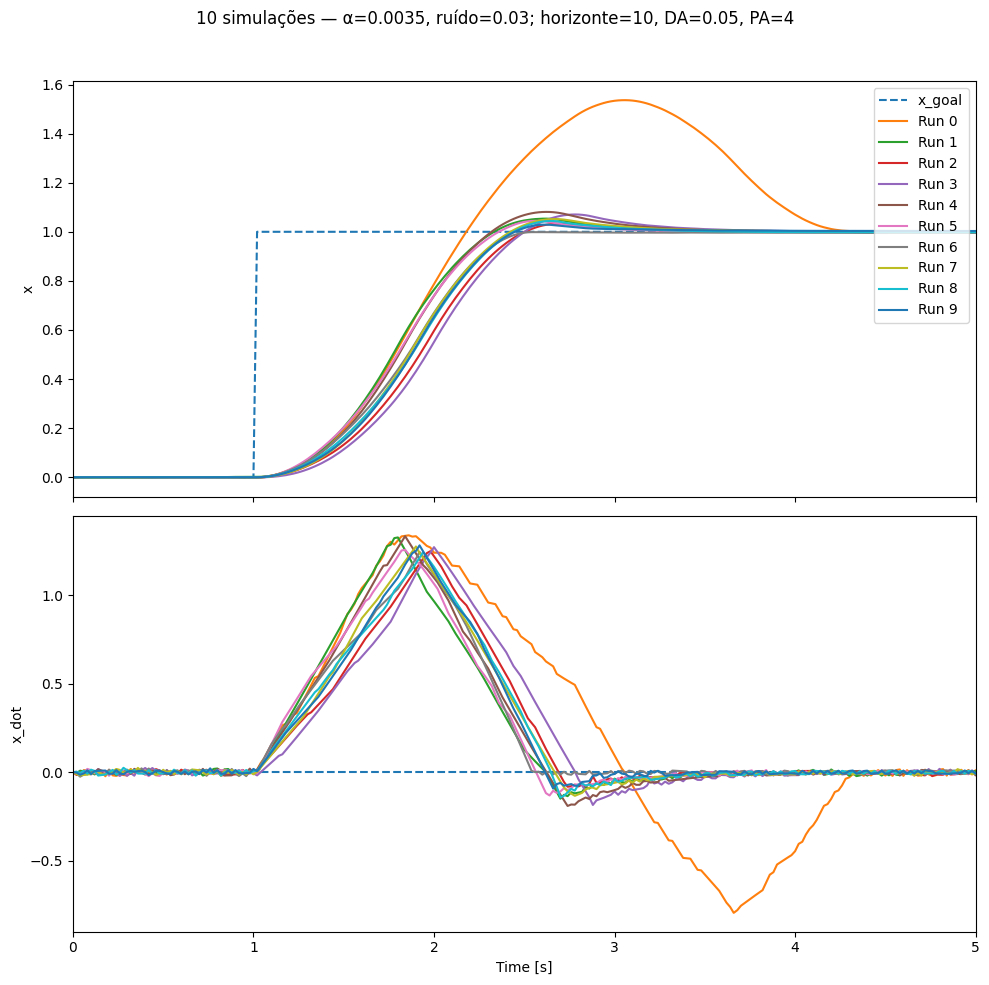

In [17]:
# Parâmetros do C++:
n_runs = 10                               # number_simulations = 10 :contentReference[oaicite:0]{index=0}
max_time = 5.0                            # segundo argumento de startSimulation = 5
horizon = 10                              # quinto argumento de startSimulation = 10
noise = 0.03                              # noise<< 0.03 no seu C++ 
actions_state_possible = 4                # definido no C++ como 4
u_min, u_max, u_step = -0.2, 0.2, 0.05     # discretization_actions << -0.2, 0.2, 0.05
DA = u_step
PA = actions_state_possible
prefix = "UniratyStep"                    # primeiro argumento de startSimulation
data_dir = "Data/Unitary/1"               # pasta onde o C++ salvou os CSVs

# Carrega os dados e cria rótulos
Data = []
labels = []
for i in range(n_runs):
    fname = f"{data_dir}/{prefix}Data{i}.csv"   # padrão NameBase + "Data" + índice + ".csv" :contentReference[oaicite:1]{index=1}
    D = read_one(fname)
    Data.append(D)
    labels.append(f"Run {i}")

# Monta o título para o gráfico
title = (
    f"{n_runs} simulações — "
    f"α=0.0035, ruído={noise}; "
    f"horizonte={horizon}, DA={DA}, PA={PA}"
)

# Plota com limite de tempo igual ao max_time do C++
Create_1D_Graphic2(title, labels, Data, t=max_time)


# Rampa

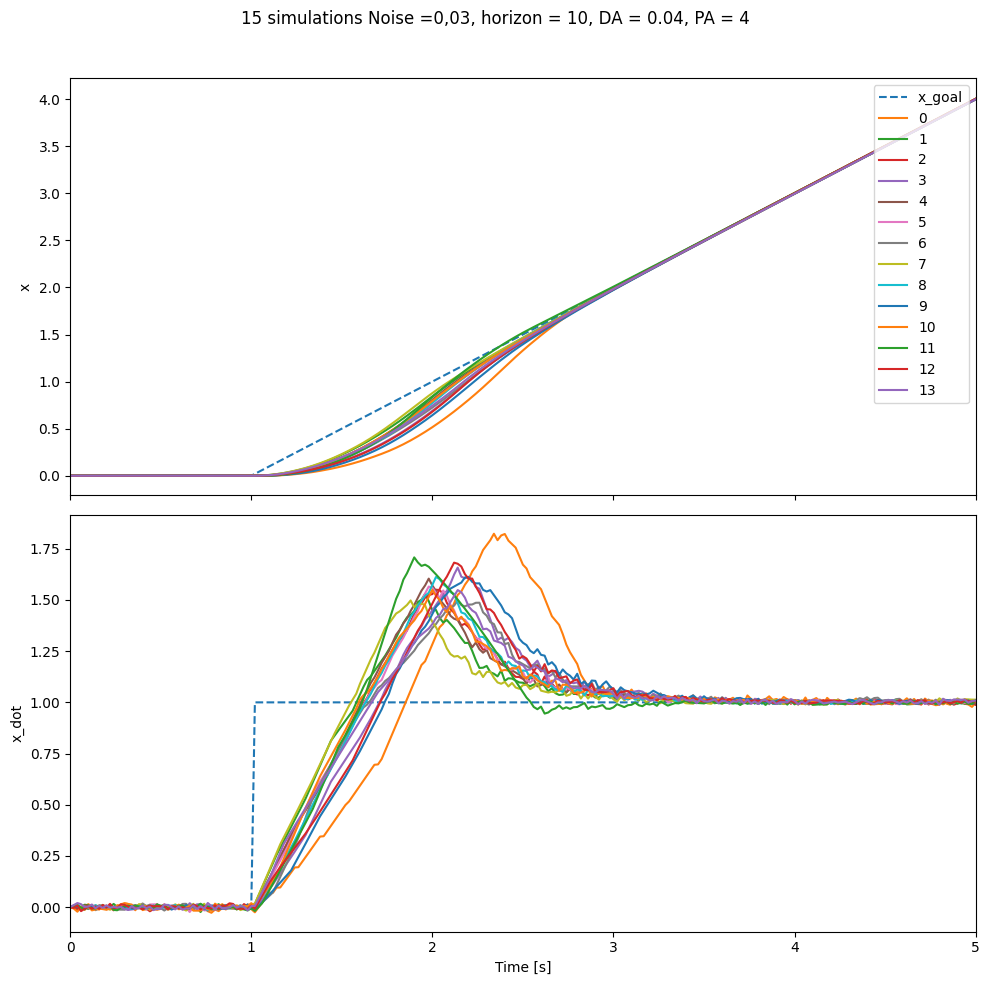

In [14]:
# Defined variables alpha = 0.0035 , horizon =10, actions_possibles = 4;
Data = []
L = []
D = []
for i in range(14):
    D = read_one(f'Data/Ramp/RampData{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic("15 simulations Noise =0,03, horizon = 10, DA = 0.04, PA = 4", L, Data) 

# Cosseno tentativa


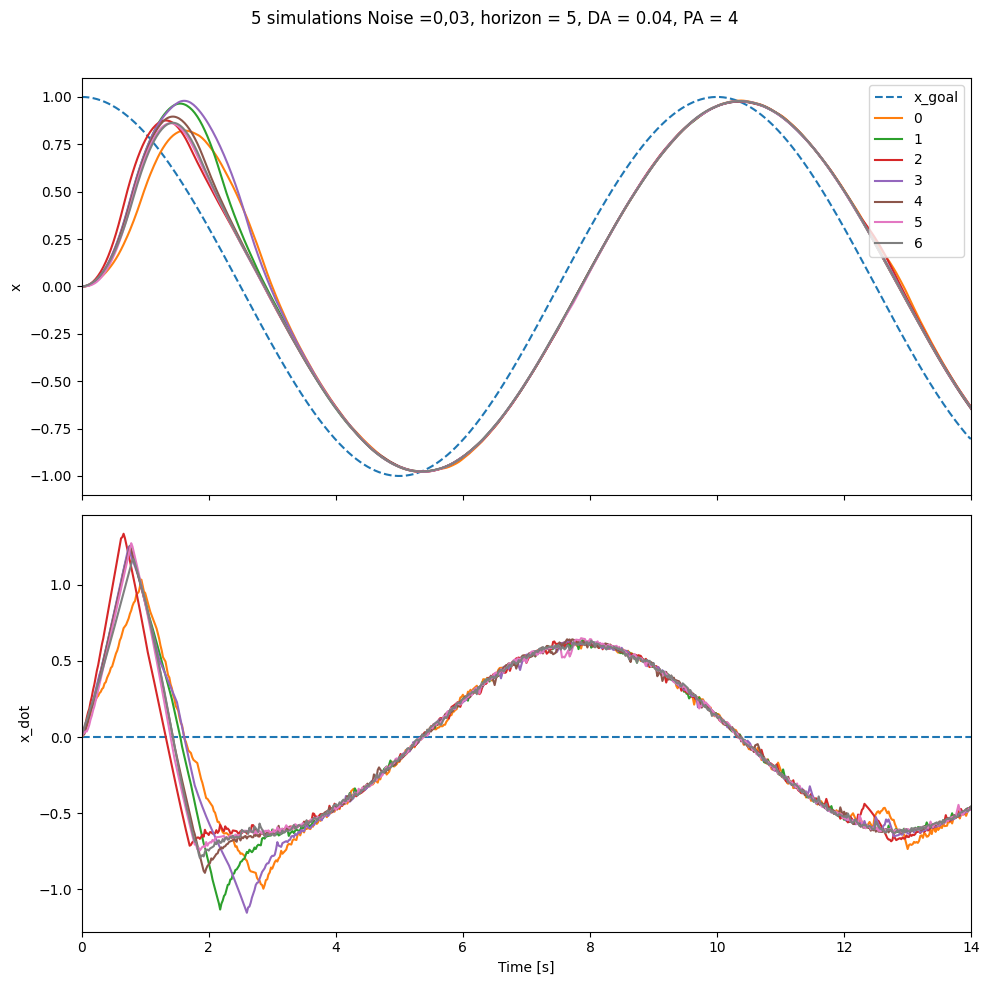

In [ ]:
Data = []
L = []
D = []
for i in range(7):
    D = read_one(f'DataFinal/8S/CosineTrackingData{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic2("7 simulations Noise =0,03, horizon = 5, DA = 0.04, PA = 4", L, Data, 14) 

Com um tempo e um horizonte um pouco maiores

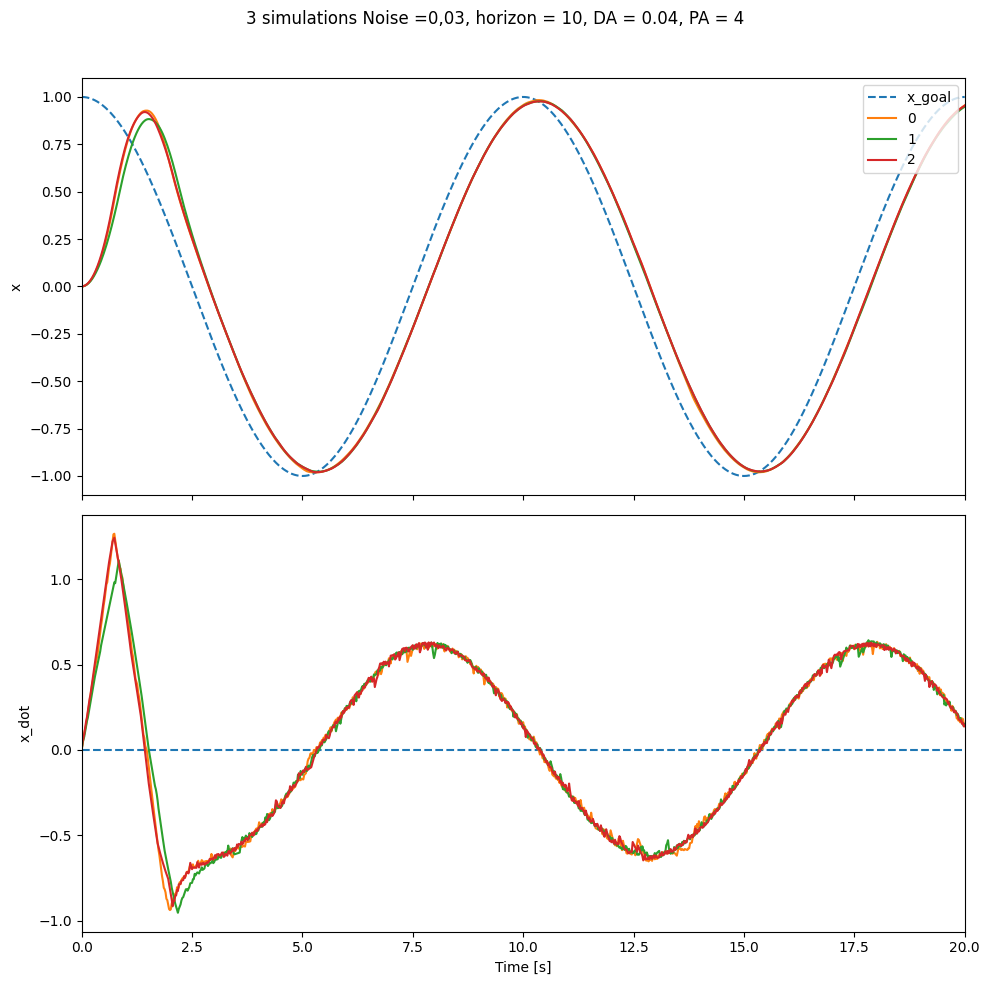

In [19]:
Data = []
L = []
D = []
for i in range(3):
    D = read_one(f'DataFinal/8S/CosineTracking20Data{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic2("3 simulations Noise =0,03, horizon = 10, DA = 0.04, PA = 4", L, Data, 20) 

Agora com alfa beta e delta(antes tava só com alfa)

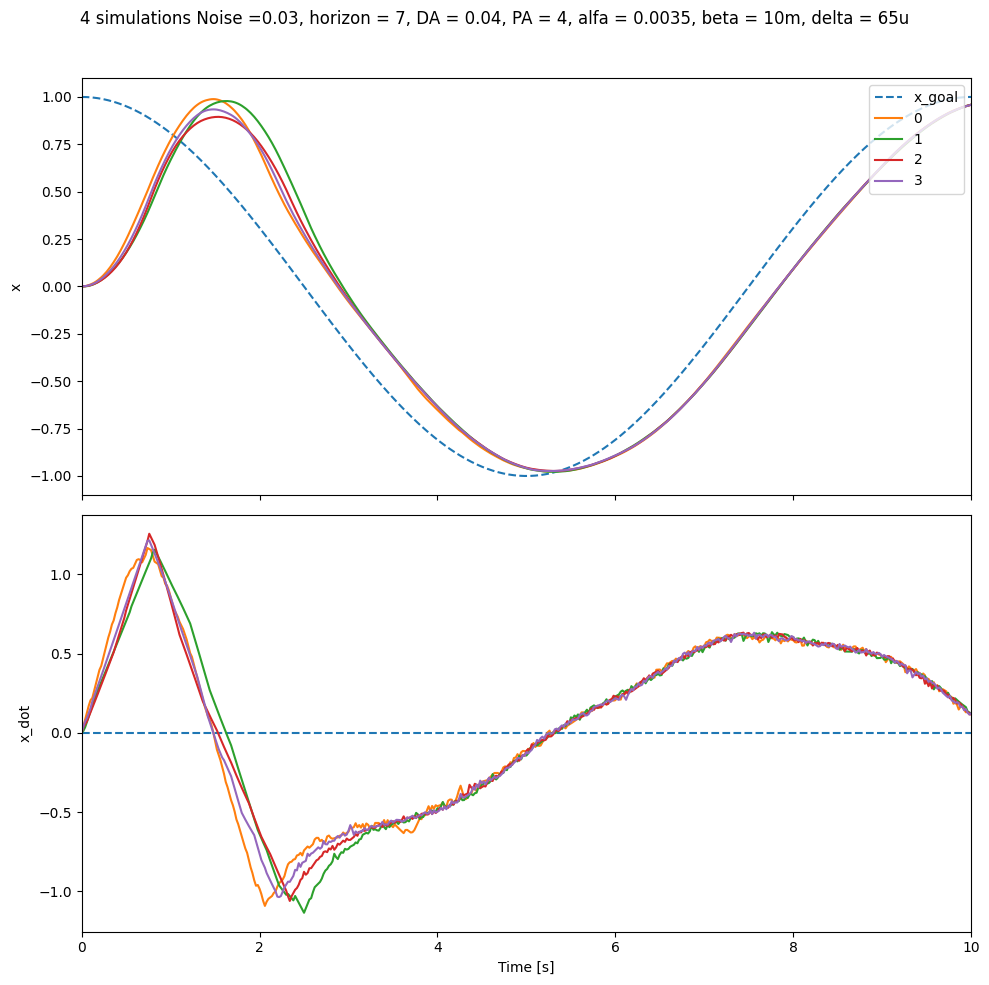

In [26]:
Data = []
L = []
D = []
for i in range(4):
    D = read_one(f'DataFinal/8S/CosineTrackingABDData{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic2("4 simulations Noise =0.03, horizon = 7, DA = 0.04, PA = 4, alfa = 0.0035, beta = 10m, delta = 65u", L, Data, 10) 

Com um integrador (Tentativa) - Pois o erro de regime permanente ainda estava grande

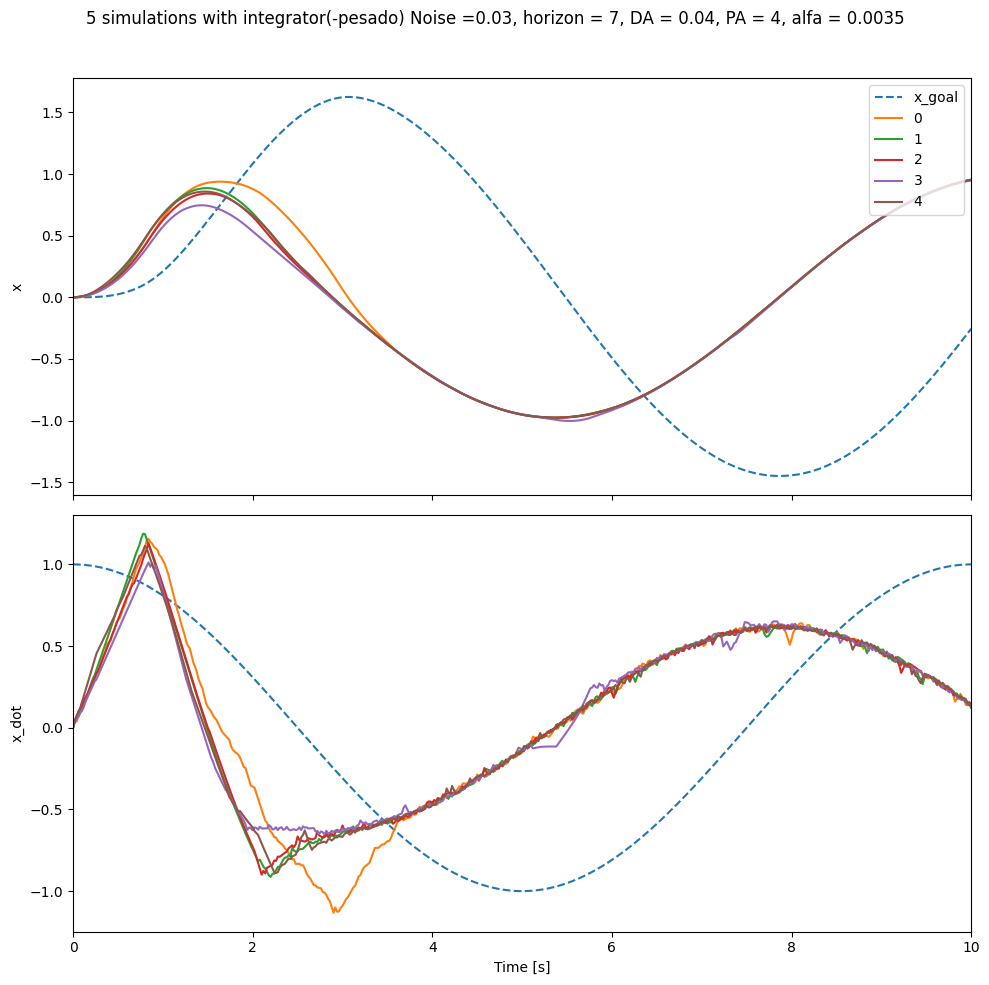

In [25]:
Data = []
L = []
D = []
for i in range(5):
    D = read_one(f'DataFinal/8S/Integrador/CosineInteg2Data{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic2("5 simulations with integrator(-pesado) Noise =0.03, horizon = 7, DA = 0.04, PA = 4, alfa = 0.0035", L, Data, 10) 

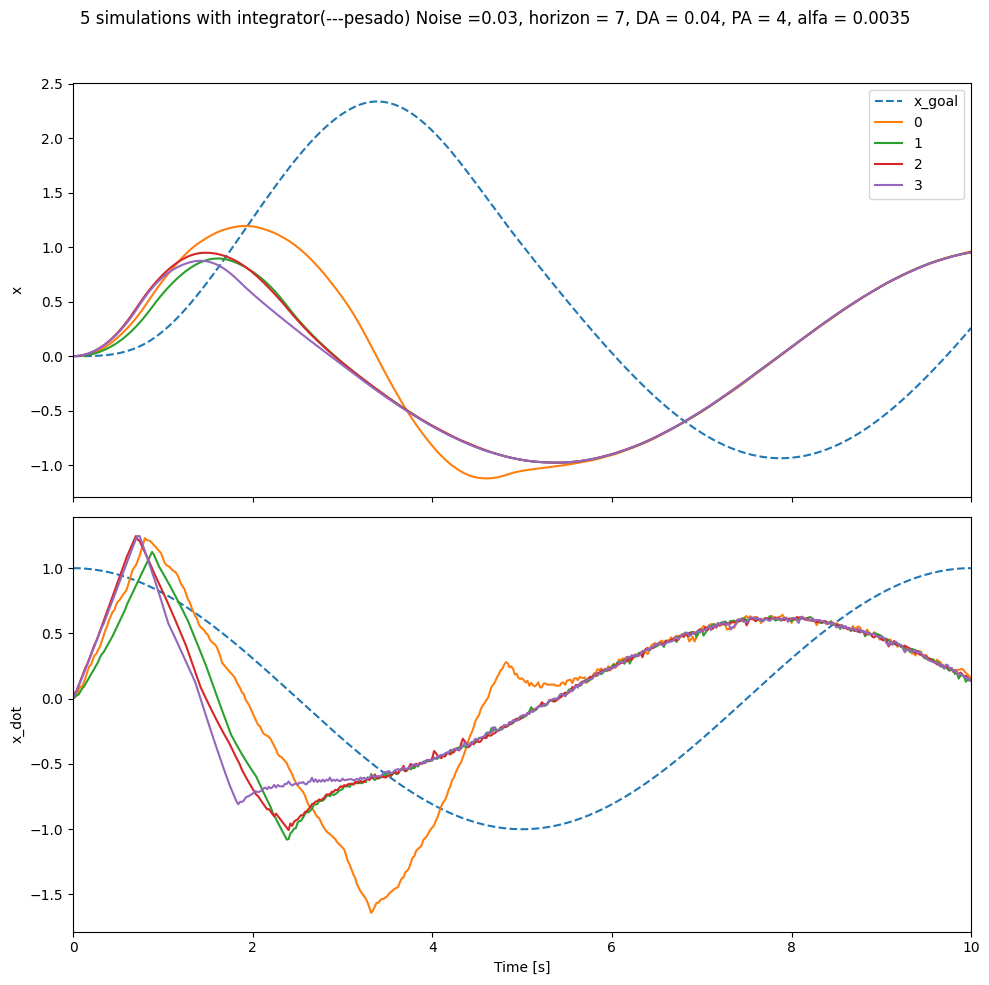

In [28]:
Data = []
L = []
D = []
for i in range(4):
    D = read_one(f'DataFinal/8S/Integrador/CosineInteg3Data{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic2("5 simulations with integrator(---pesado) Noise =0.03, horizon = 7, DA = 0.04, PA = 4, alfa = 0.0035", L, Data, 10) 

# Outro teste com cosseno e carga

Ficou interessante mas não sei se tá certo.

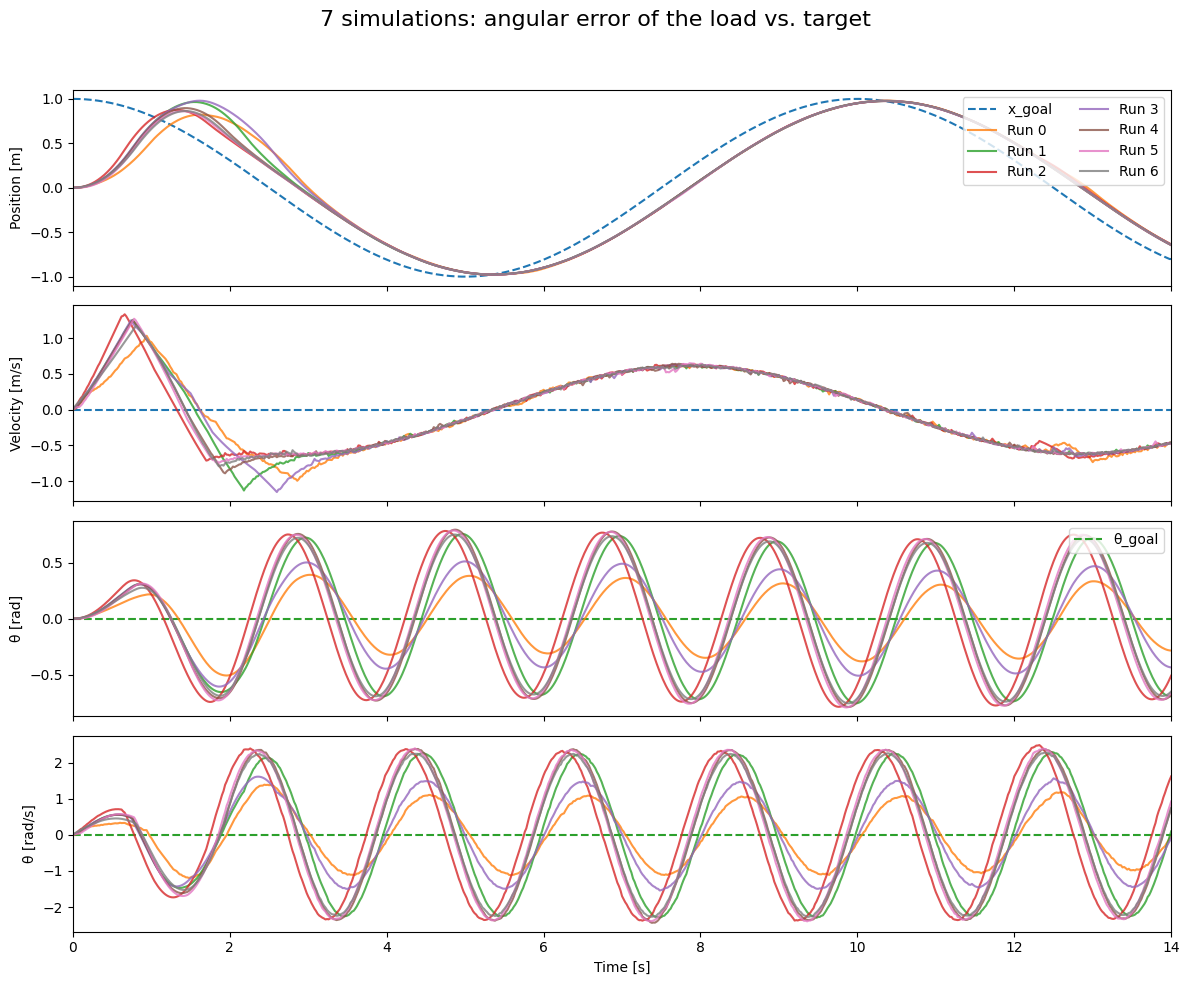

In [3]:
Data = []
Labels = []
for i in range(7):
    # use n_states=4 para incluir θ e θ̇
    D = read_generic(f'DataFinal/8S/CosineTrackingData{i}.csv', n_states=4)
    Data.append(D)
    Labels.append(f'Run {i}')

Create_Load_Graphic(
    "7 simulations: angular error of the load vs. target",
    Labels,
    Data,
    t_lim=14
)

# Tentativa Eliptico

Simulation0 mean trial = 80
Simulation1 mean trial = 1
Simulation2 mean trial = 1
Simulation3 mean trial = 1
Simulation4 mean trial = 1


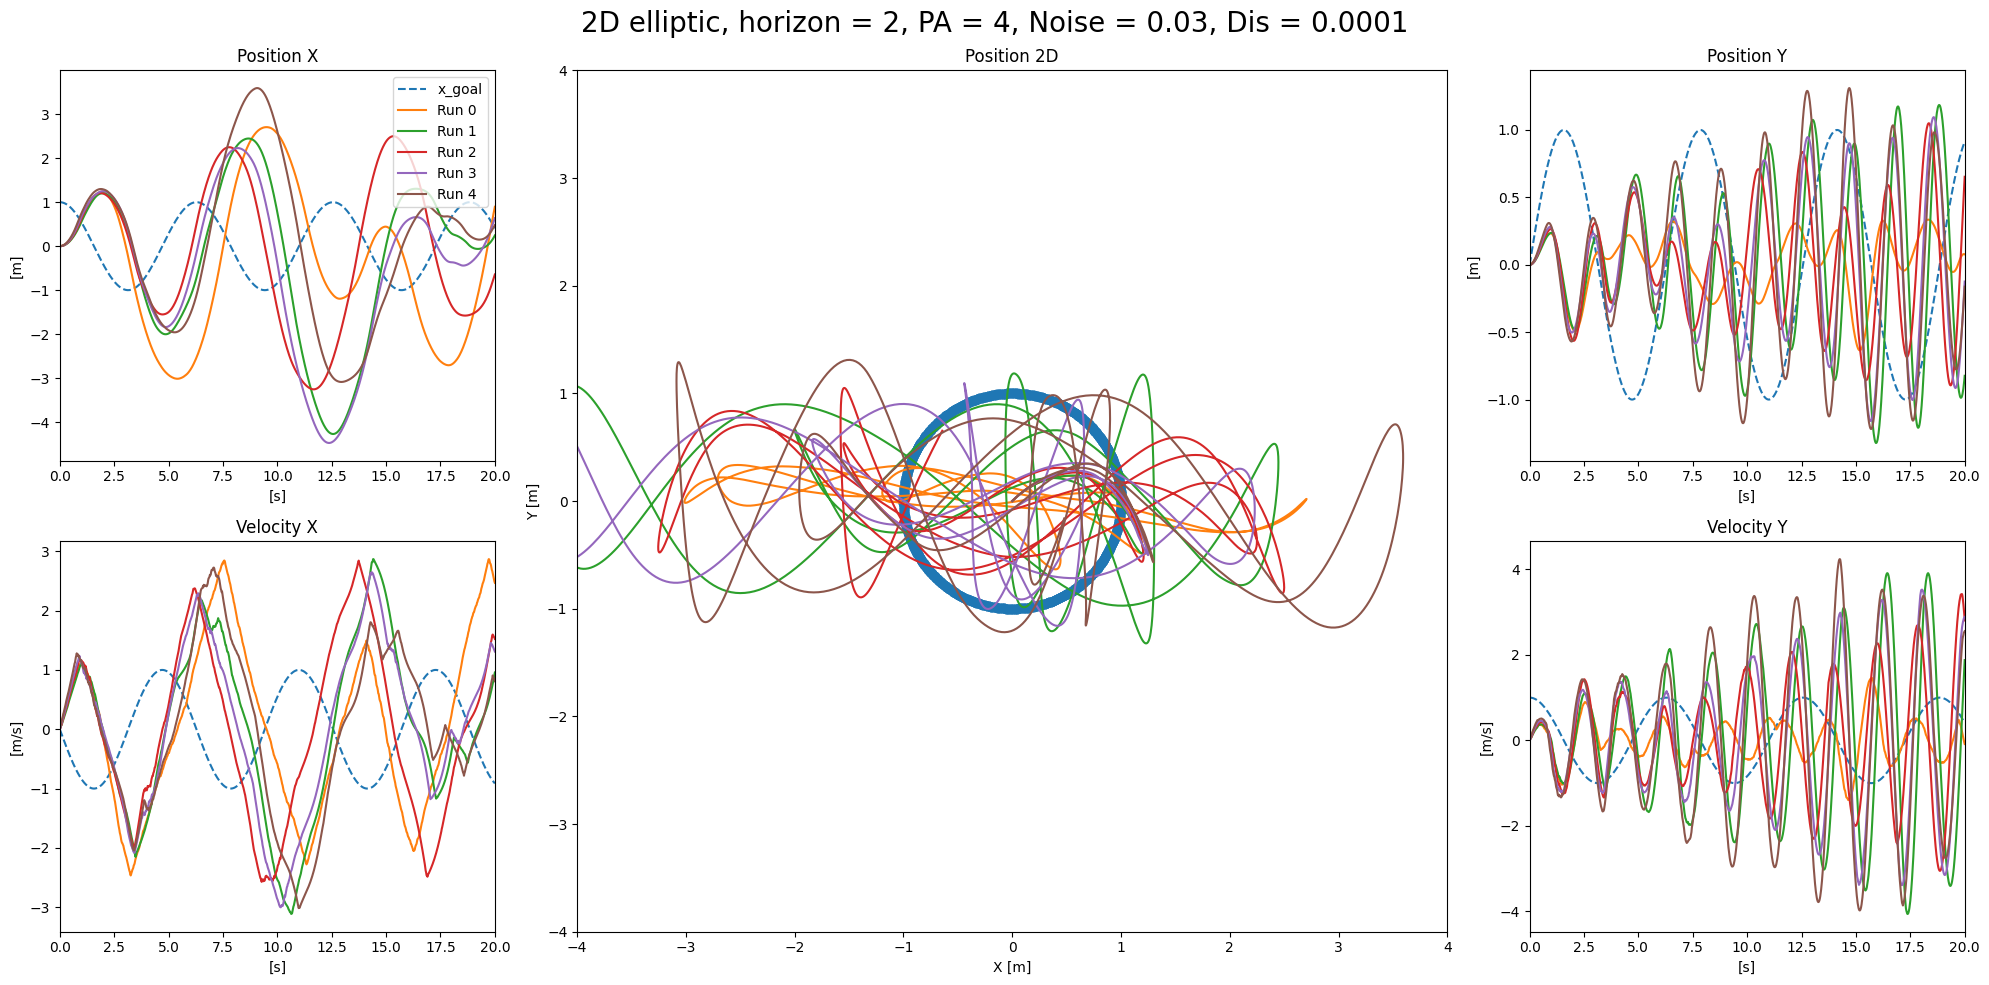

In [12]:
import statistics
import numpy as np

# 1) Carrega os 5 arquivos brutos da simulação
A = []
for i in range(5):
    path = f'Data2/2D/Eliptic/Coupled/2DelpticH22Data{i}.csv'
    A.append(read_one_2D(path))

# 2) Para cada simulação, computa média e desvio do campo “trial”
L = []
for idx, Data in enumerate(A):
    # Data é um dict com estes arrays: 
    #   Data['states'] shape (4, N)
    #   Data['goals']  shape (4, N)
    #   Data['t']      shape (N,)
    #   Data['trial']  shape (N,)
    trial_arr = np.asarray(Data['trial'], dtype=float)
    
    # estatísticas — stdev amostral (ddof=1)
    m = round(np.mean(trial_arr))
    s = round(np.std(trial_arr, ddof=1), 2)
    
    L.append(f"Simulation{idx} Trial = {m} + {s}")
    print(f"Simulation{idx} mean trial = {m}")

# 3) Título e chamadas de plot/animação
title = '2D elliptic, horizon = 2, PA = 4, Noise = 0.03, Dis = 0.0001'
Create_2D_Graphic(title, A, 20)
#create_animation(A, title, L, 'elliptical_coupled_model')


# Eliptico tentativa 2

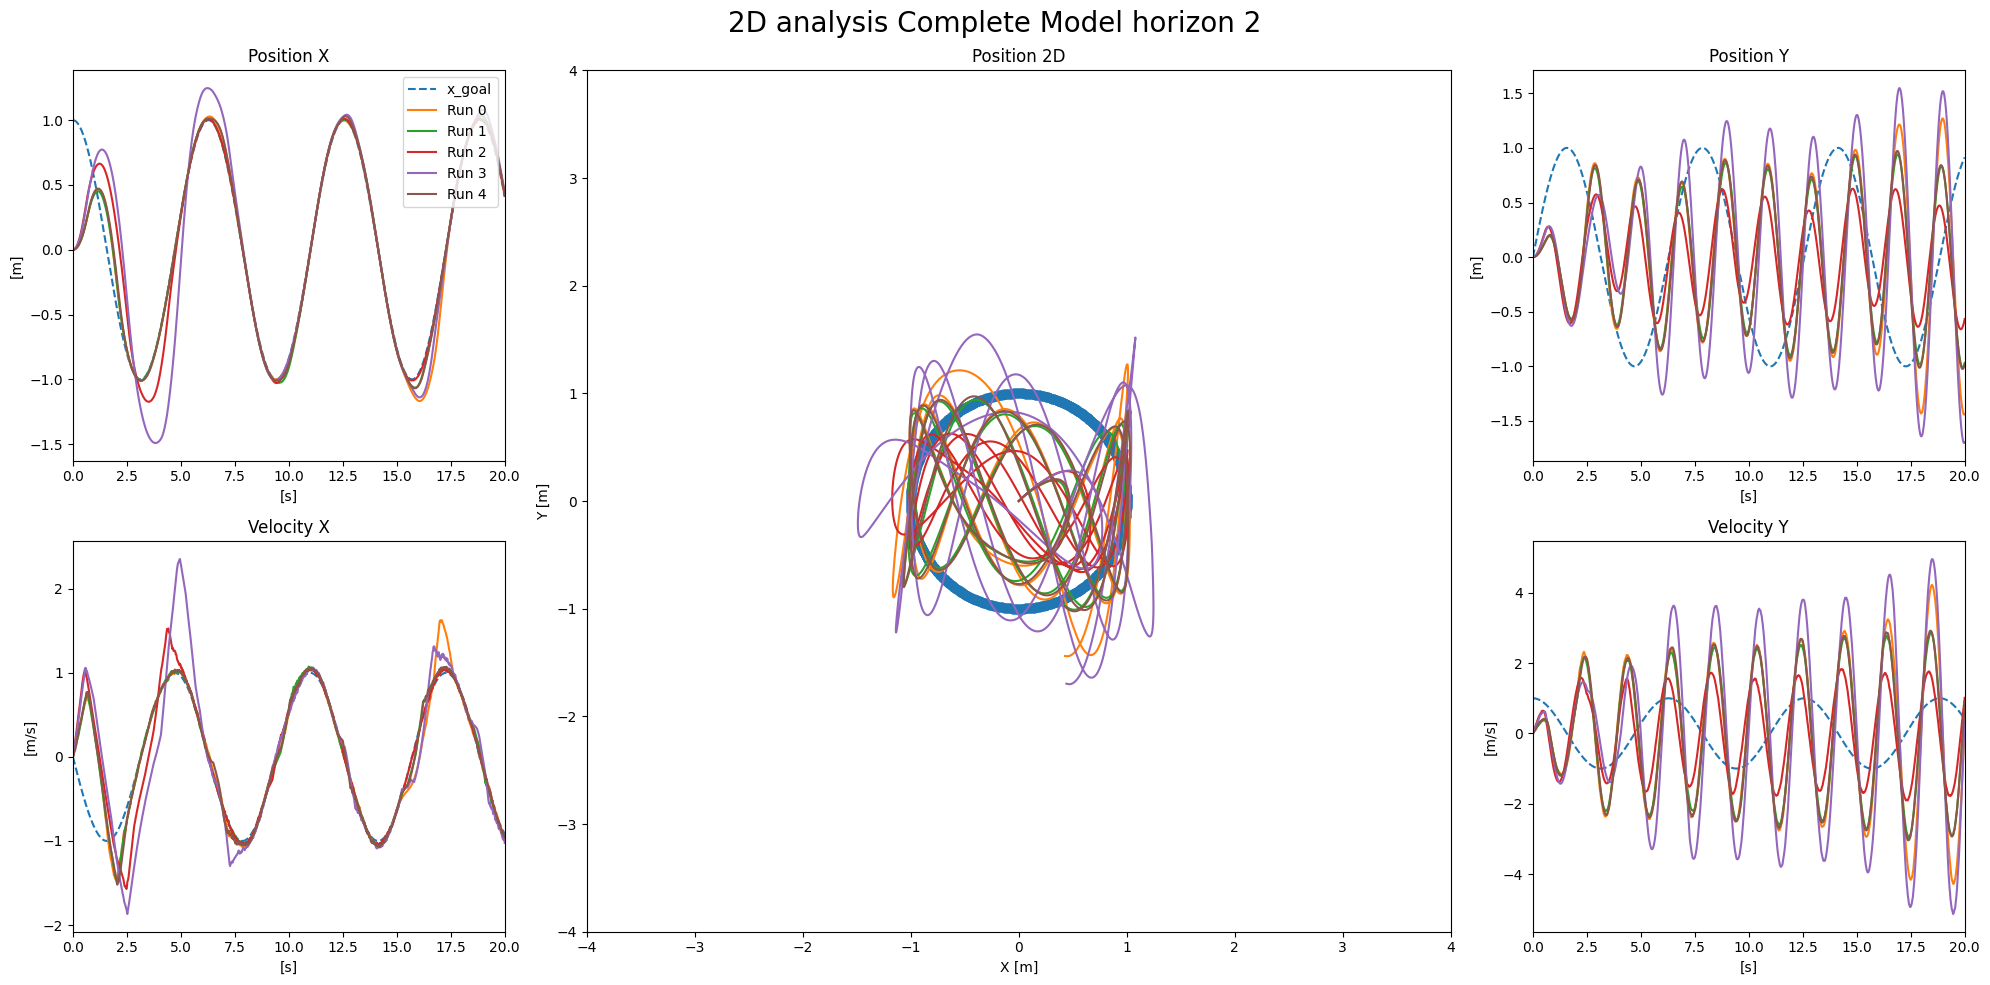

In [49]:
A = []
L = []
for i in range(5):
    A.append( read_one_2D(f'Data2/Elliptic/Elliptic2DDData{i}.csv'))
    


Create_2D_Graphic("2D analysis Complete Model horizon 2", A, 20)

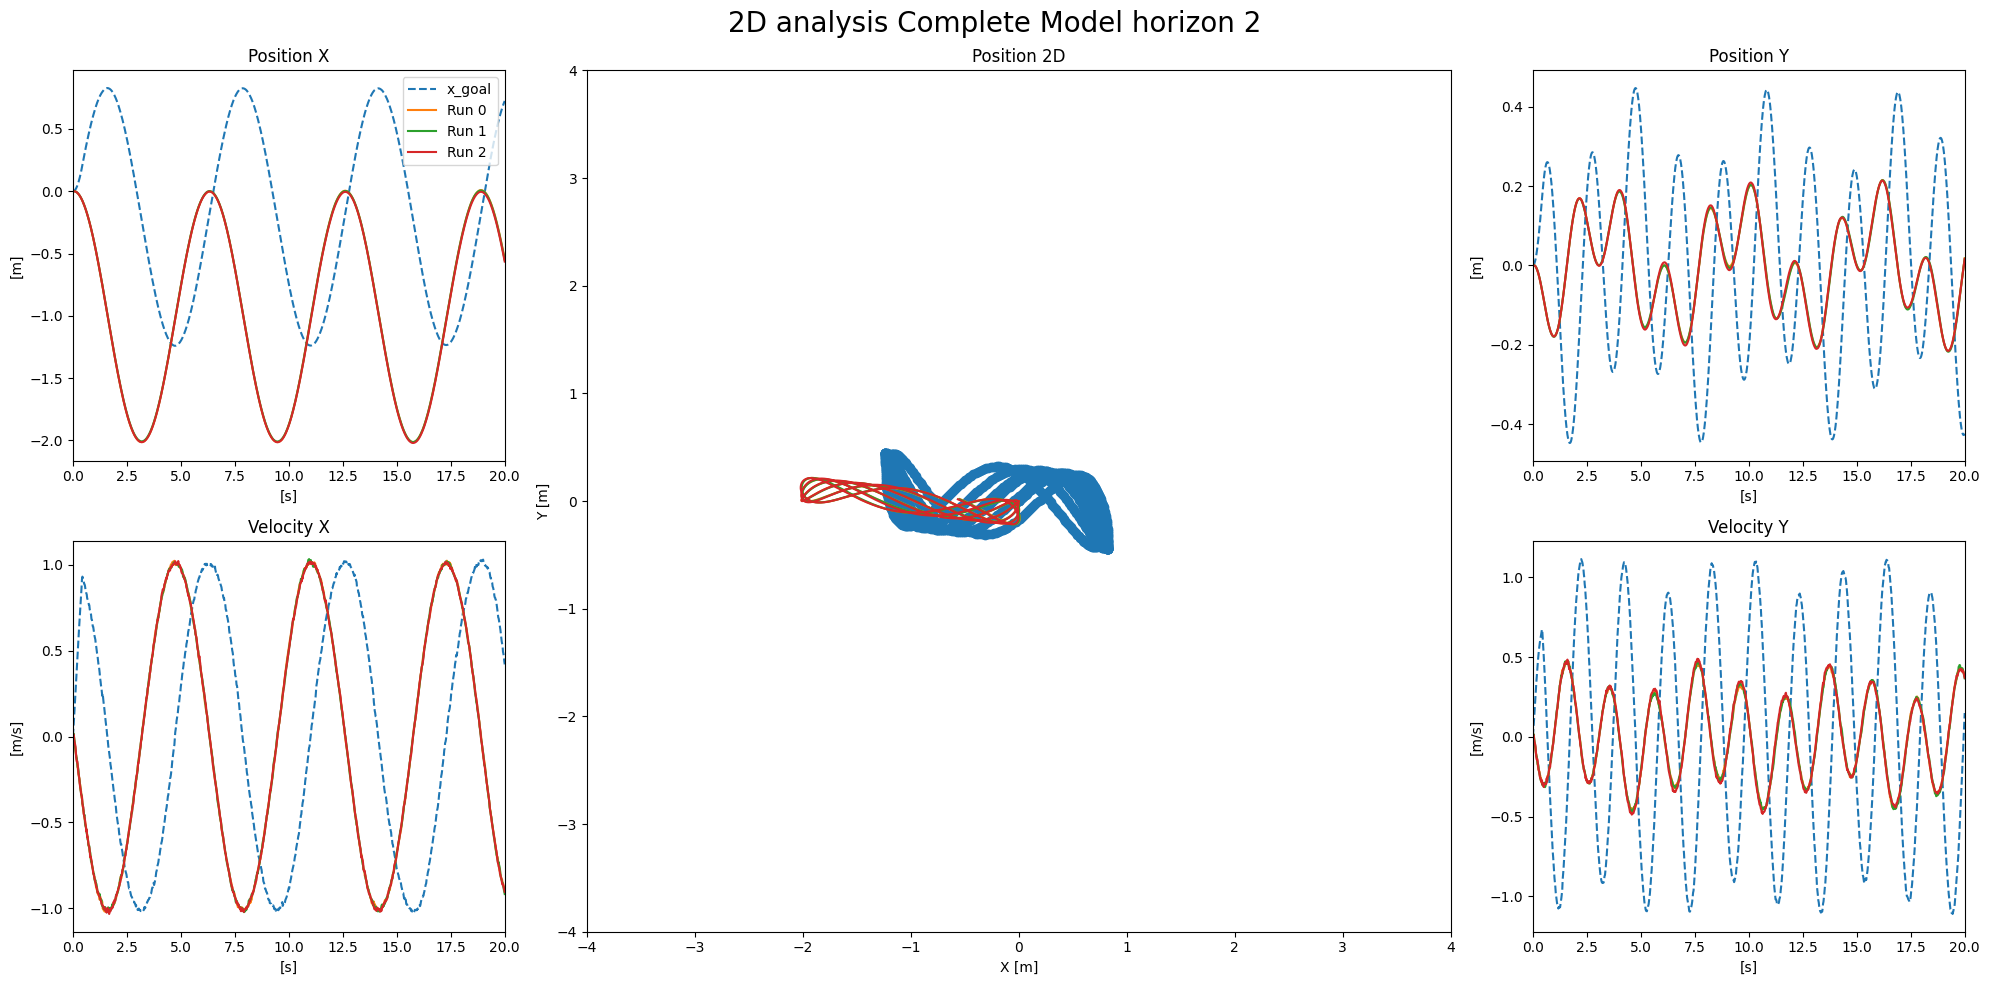

In [51]:
A = []
L = []
for i in range(3):
    A.append( read_one_2D(f'DataFinal/TesteModel/Elliptic2DDData{i}.csv'))
    


Create_2D_Graphic("2D analysis Complete Model horizon 2", A, 20)

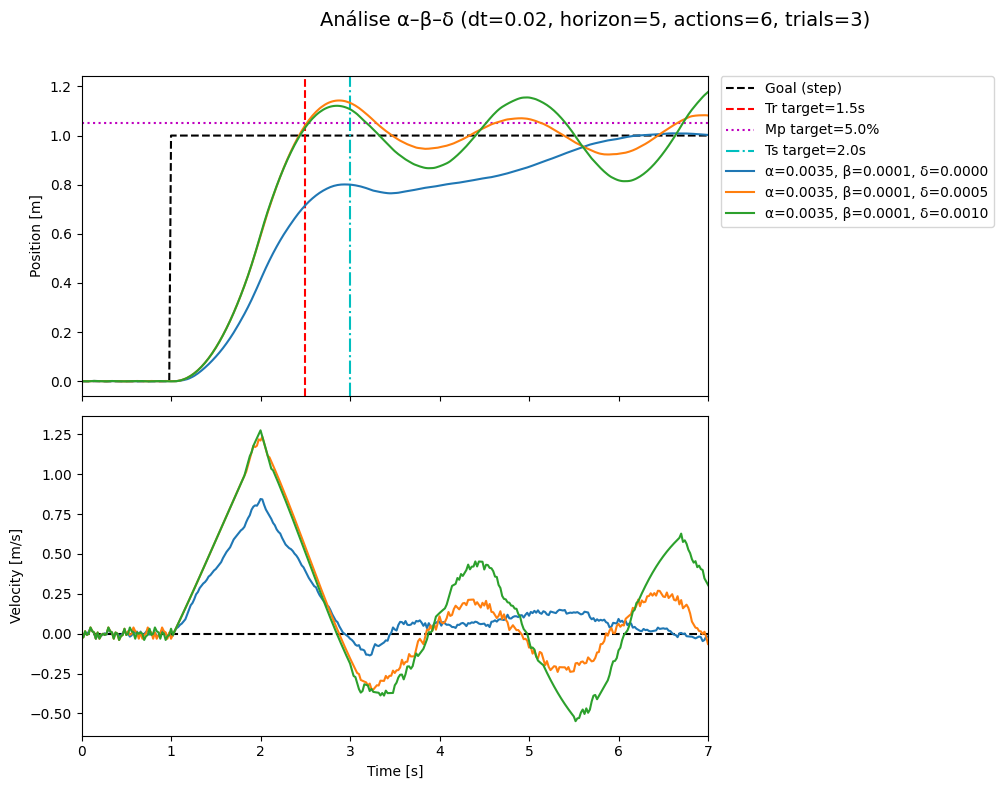

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# supondo que read_one e Create_1D_Graphic já estejam no seu escopo

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/AlphaC/1"
alphas      = [0.0035]
beta_val    = 0.0001
deltas      = [0.0000, 0.0005, 0.0010]#, 0.0015,0.0020, 0.0025, 0.0030, 0.0035, 0.0040]
trials      = 3  # conforme const int trials = 3

for a in alphas:
    for d in deltas:
        tag = f"A{a:.4f}_B{beta_val:.4f}_D{d:.4f}"

        trial_dicts = []
        for t in range(trials):
            fname = f"{tag}Data_avg.csv"
            path  = os.path.join(base_folder, fname)
            if not os.path.isfile(path):
                print(f"[AVISO] não encontrou: {path}")
                continue
            trial_dicts.append(read_one(path))

        if not trial_dicts:
            continue

        avg_dict = {}
        for key in trial_dicts[0].keys():
            arrs = np.stack([dct[key] for dct in trial_dicts], axis=0)
            avg_dict[key] = np.mean(arrs, axis=0)

        Data.append(avg_dict)
        subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={d:.4f}")

# chama seu plot
Create_1D_Graphic(
    "Análise α–β–δ (dt=0.02, horizon=5, actions=6, trials=3)",
    subtitles,
    Data
)

# *** AQUI A PARTE NOVA: ***
# Ajusta TODOS os eixos da figura atual para irem de 0 a 10 segundos
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 10)

# E ajusta as margens manualmente para caber a legenda/título
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)

plt.show()


# Coisa do Marcos

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\3709042749.py:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes_right = plt.subplot(1, 2, 2)


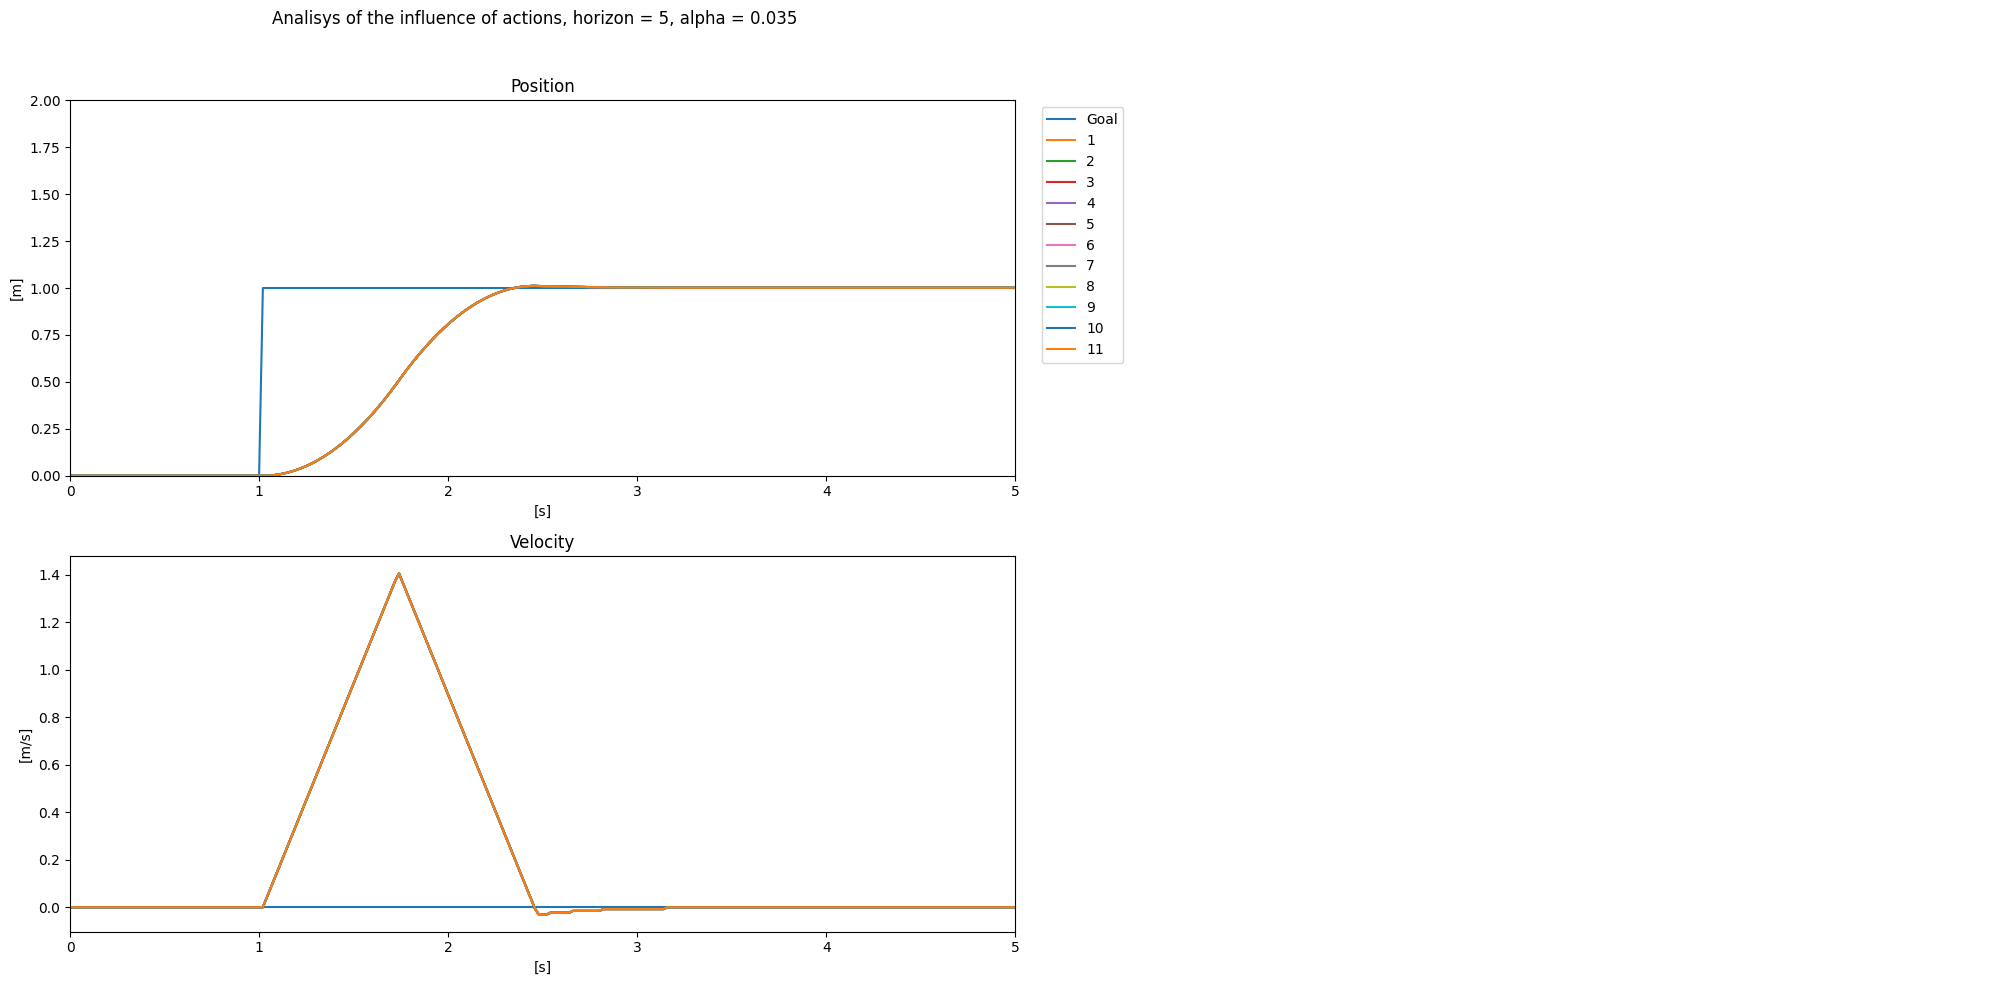

In [ ]:
Data = []
L = []
for i in range(1,12):
    Data.append(read_one(f'Data/Action/actions{i}Data0.csv'))
    L.append(i)

  
Create_1D_Graphic("Analisys of the influence of actions, horizon = 5, alpha = 0.035", L, Data) 

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\3709042749.py:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes_right = plt.subplot(1, 2, 2)


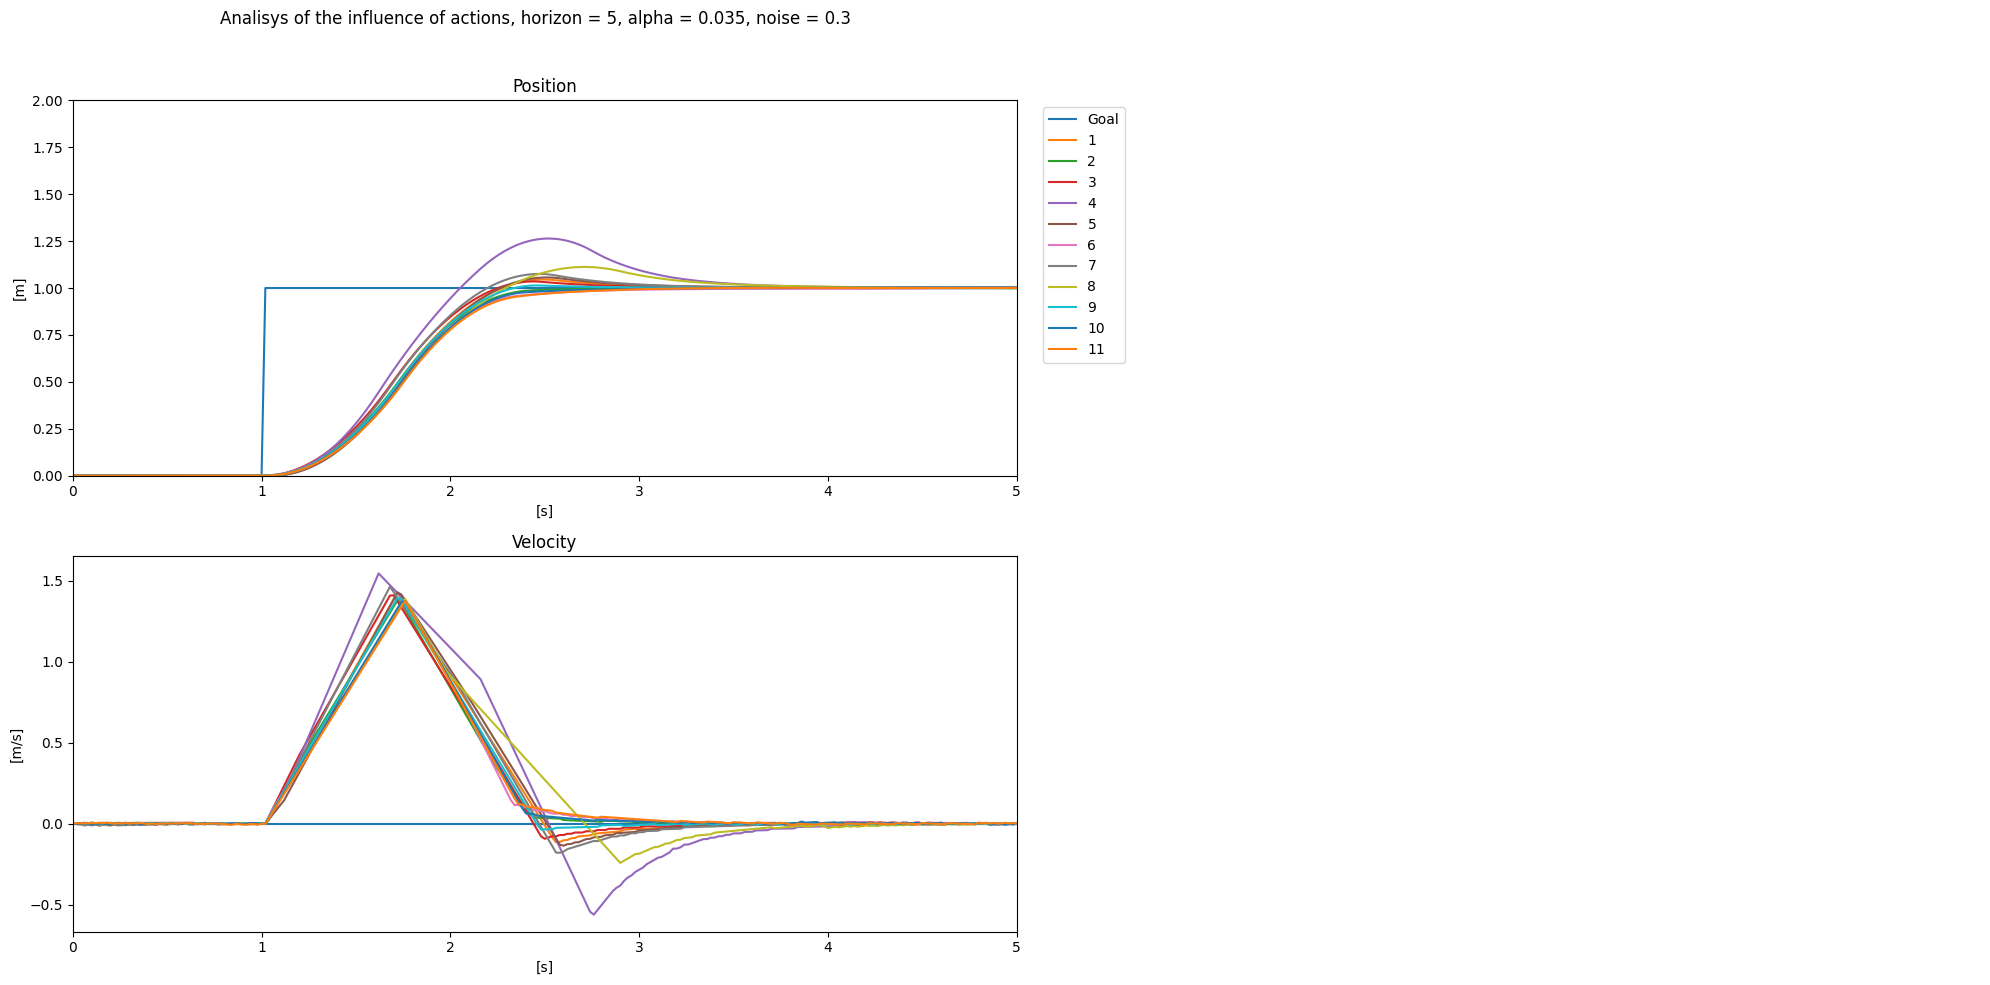

In [ ]:
Data = []
L = []
for i in range(1,12):
    Data.append(read_one(f'Data/Action/2/actionsNoise{i}Data0.csv'))
    L.append(i)

  
Create_1D_Graphic("Analisys of the influence of actions, horizon = 5, alpha = 0.035, noise = 0.3", L, Data) 

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\2095646794.py:107: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



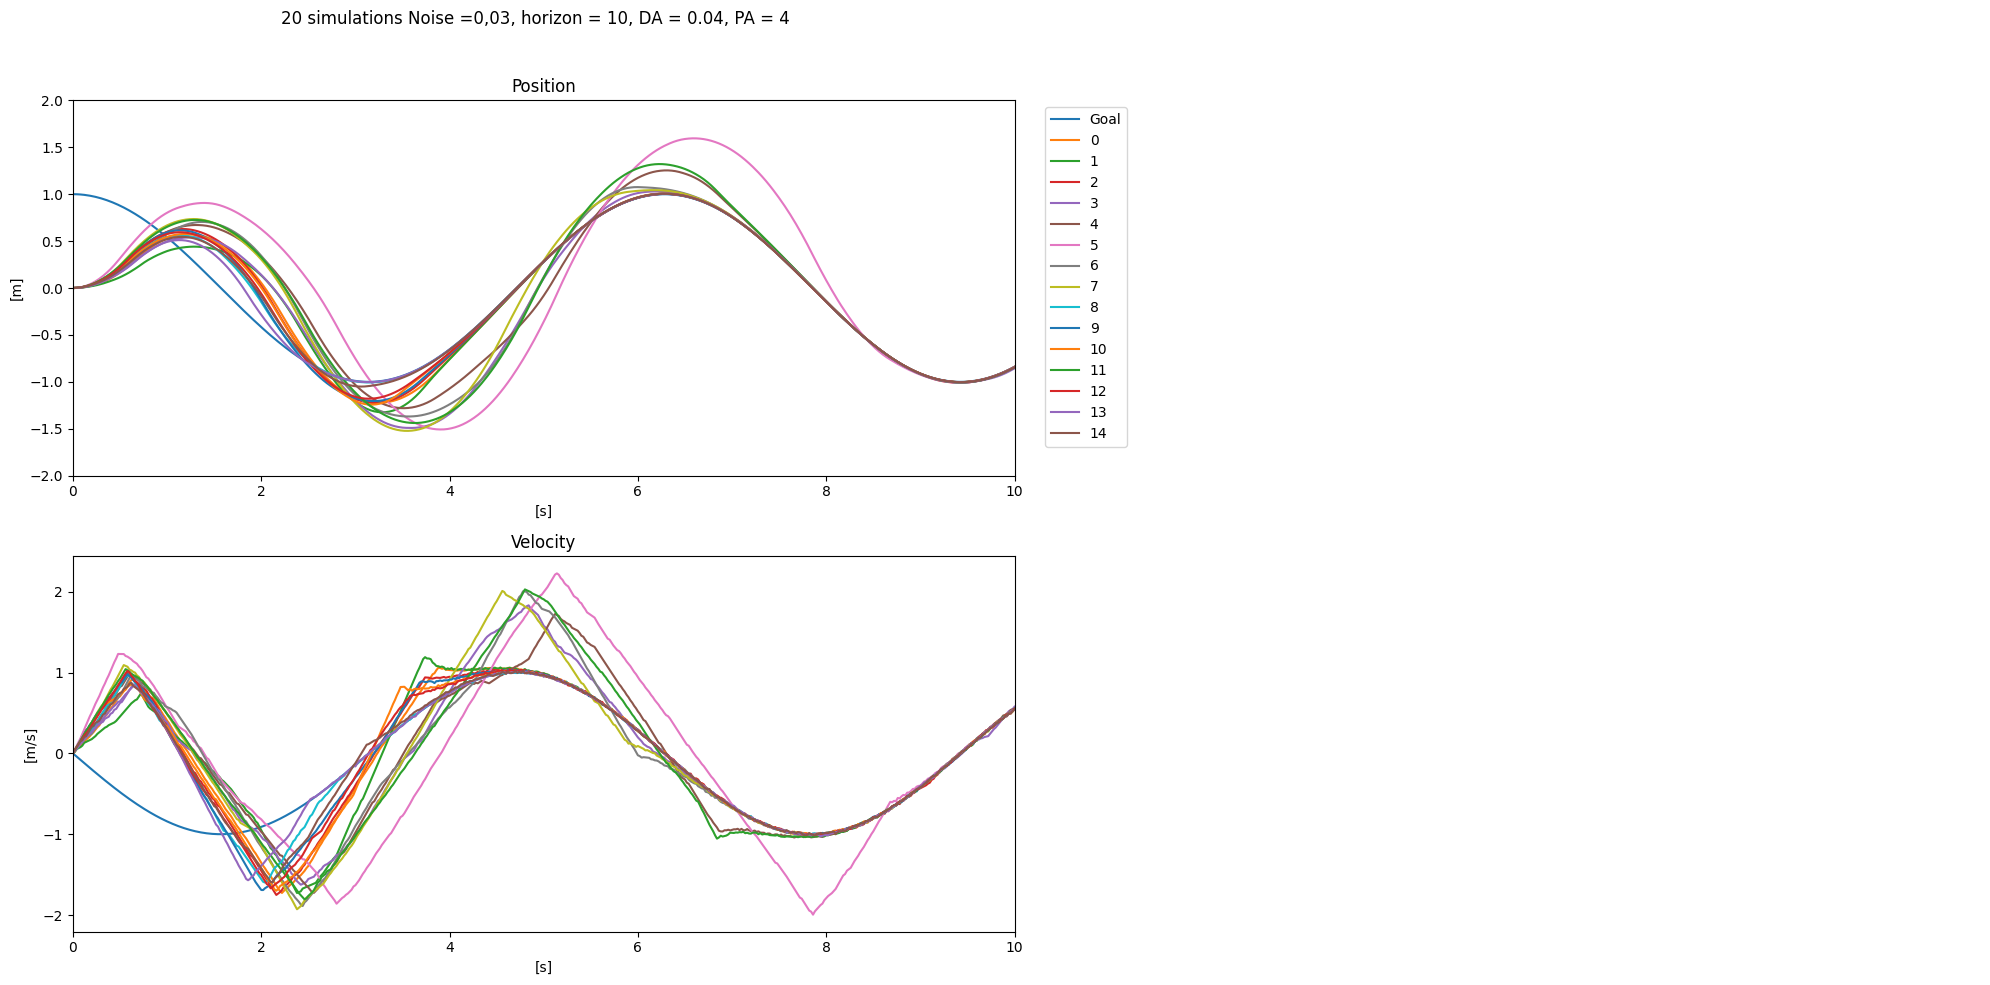

In [ ]:
Data = []
L = []
D = []
for i in range(15):
    D = read_one(f'Data/Cos/Cos15Data{i}.csv')
    Data.append(D)
    L.append(f'{i}')
Create_1D_Graphic2("20 simulations Noise =0,03, horizon = 10, DA = 0.04, PA = 4", L, Data, 10) 

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\2095646794.py:207: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



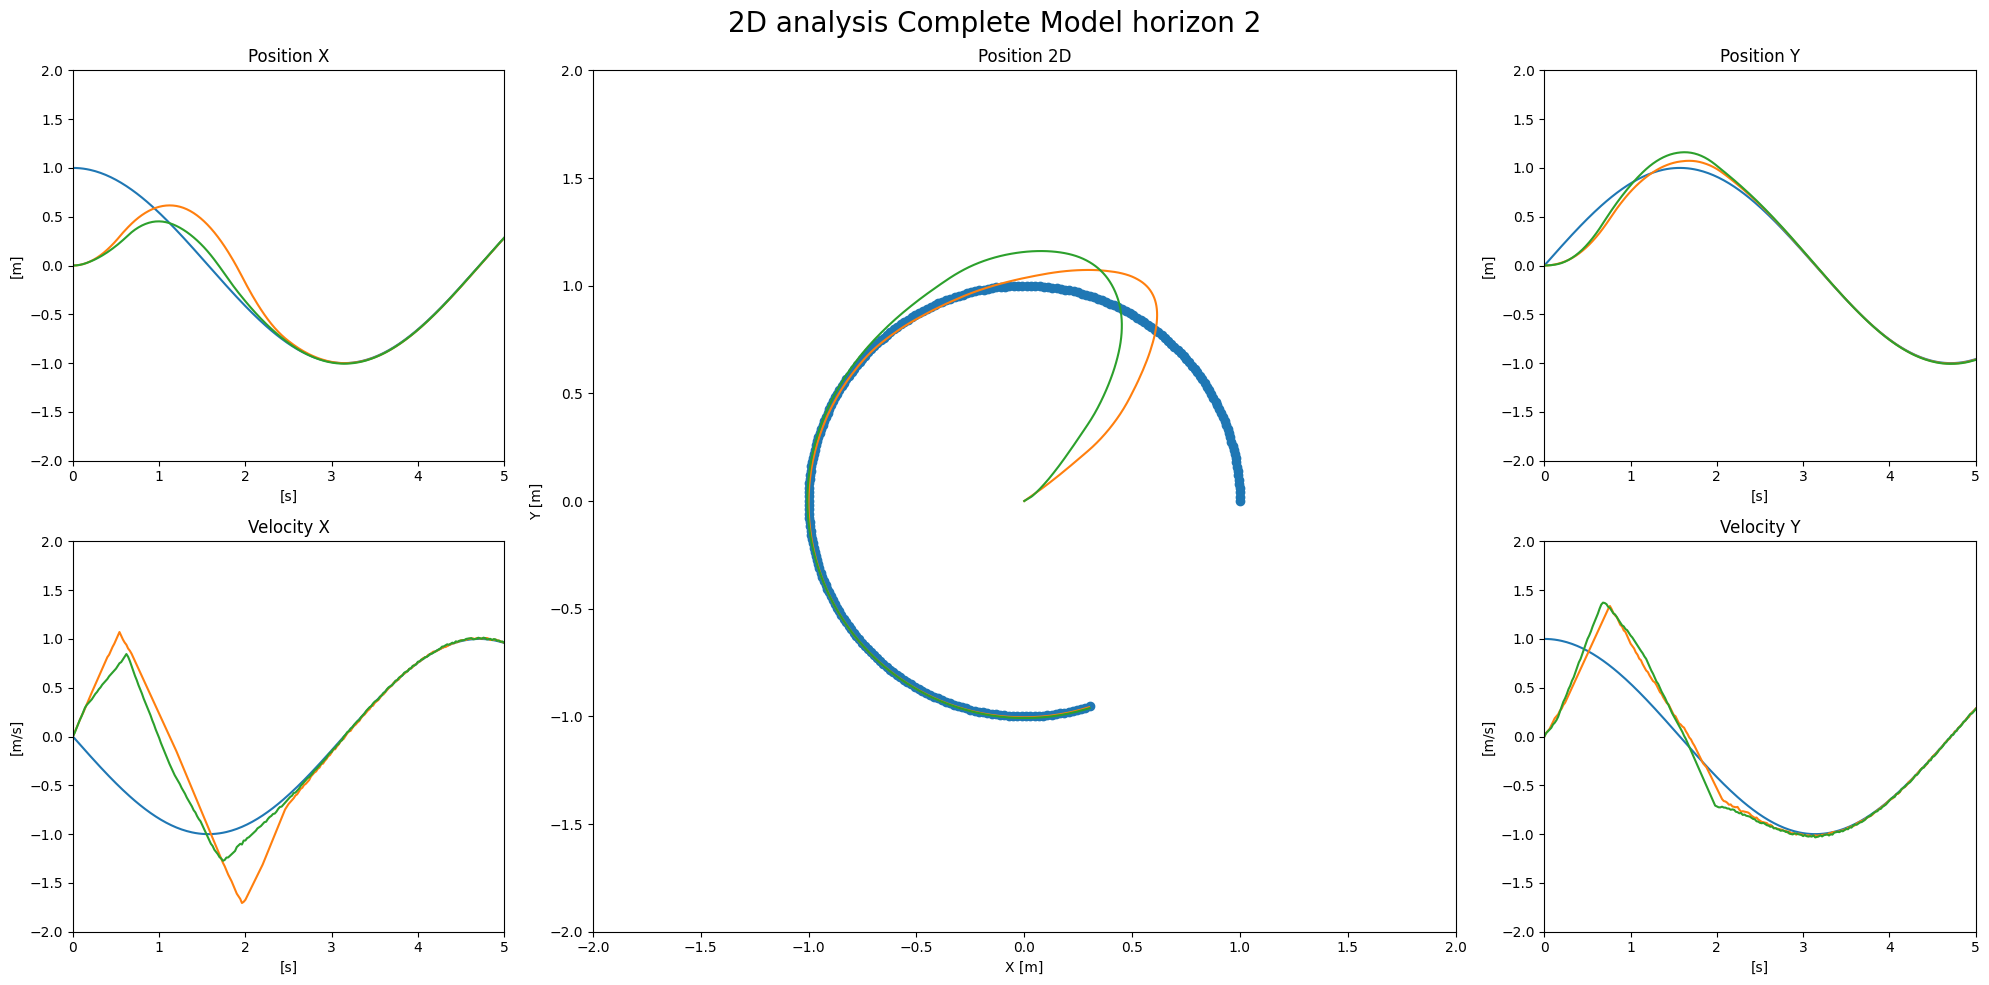

In [ ]:
A = []
L = []
#2DelpticH22Data0.csv
A.append( read_one_2D(f'2DelpticH22Data0.csv'))
A.append( read_one_2D(f'2DelpticH3Data0.csv'))
# A.append( read_one_2D(f'2DelpticH2Data0.csv'))
Create_2D_Graphic("2D analysis Complete Model horizon 2", A, 5)

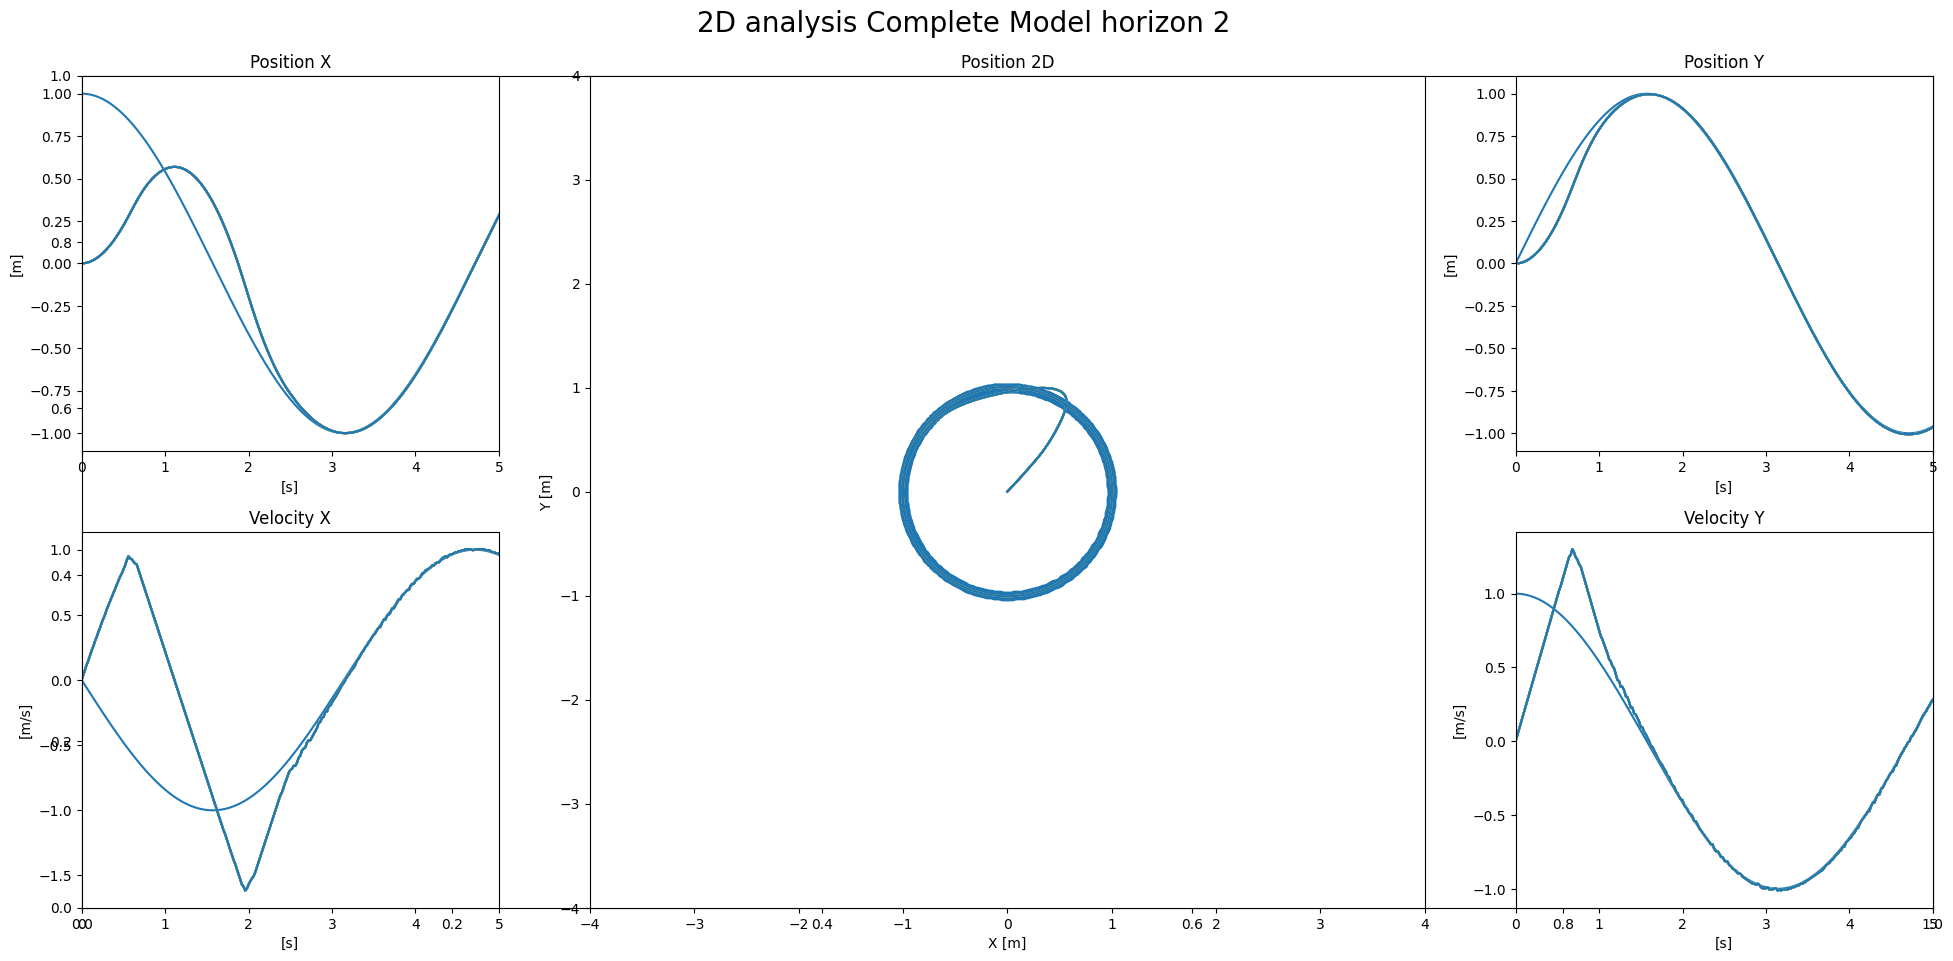

In [ ]:
A = []
L = []
for i in range(2,12):
    A.append( read_one_2D(f'Data2d/ElipticCorr/2DHorizon{i}Data0.csv'))
    


Create_2D_Graphic("2D analysis Complete Model horizon 2", A, 5)

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\2095646794.py:207: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



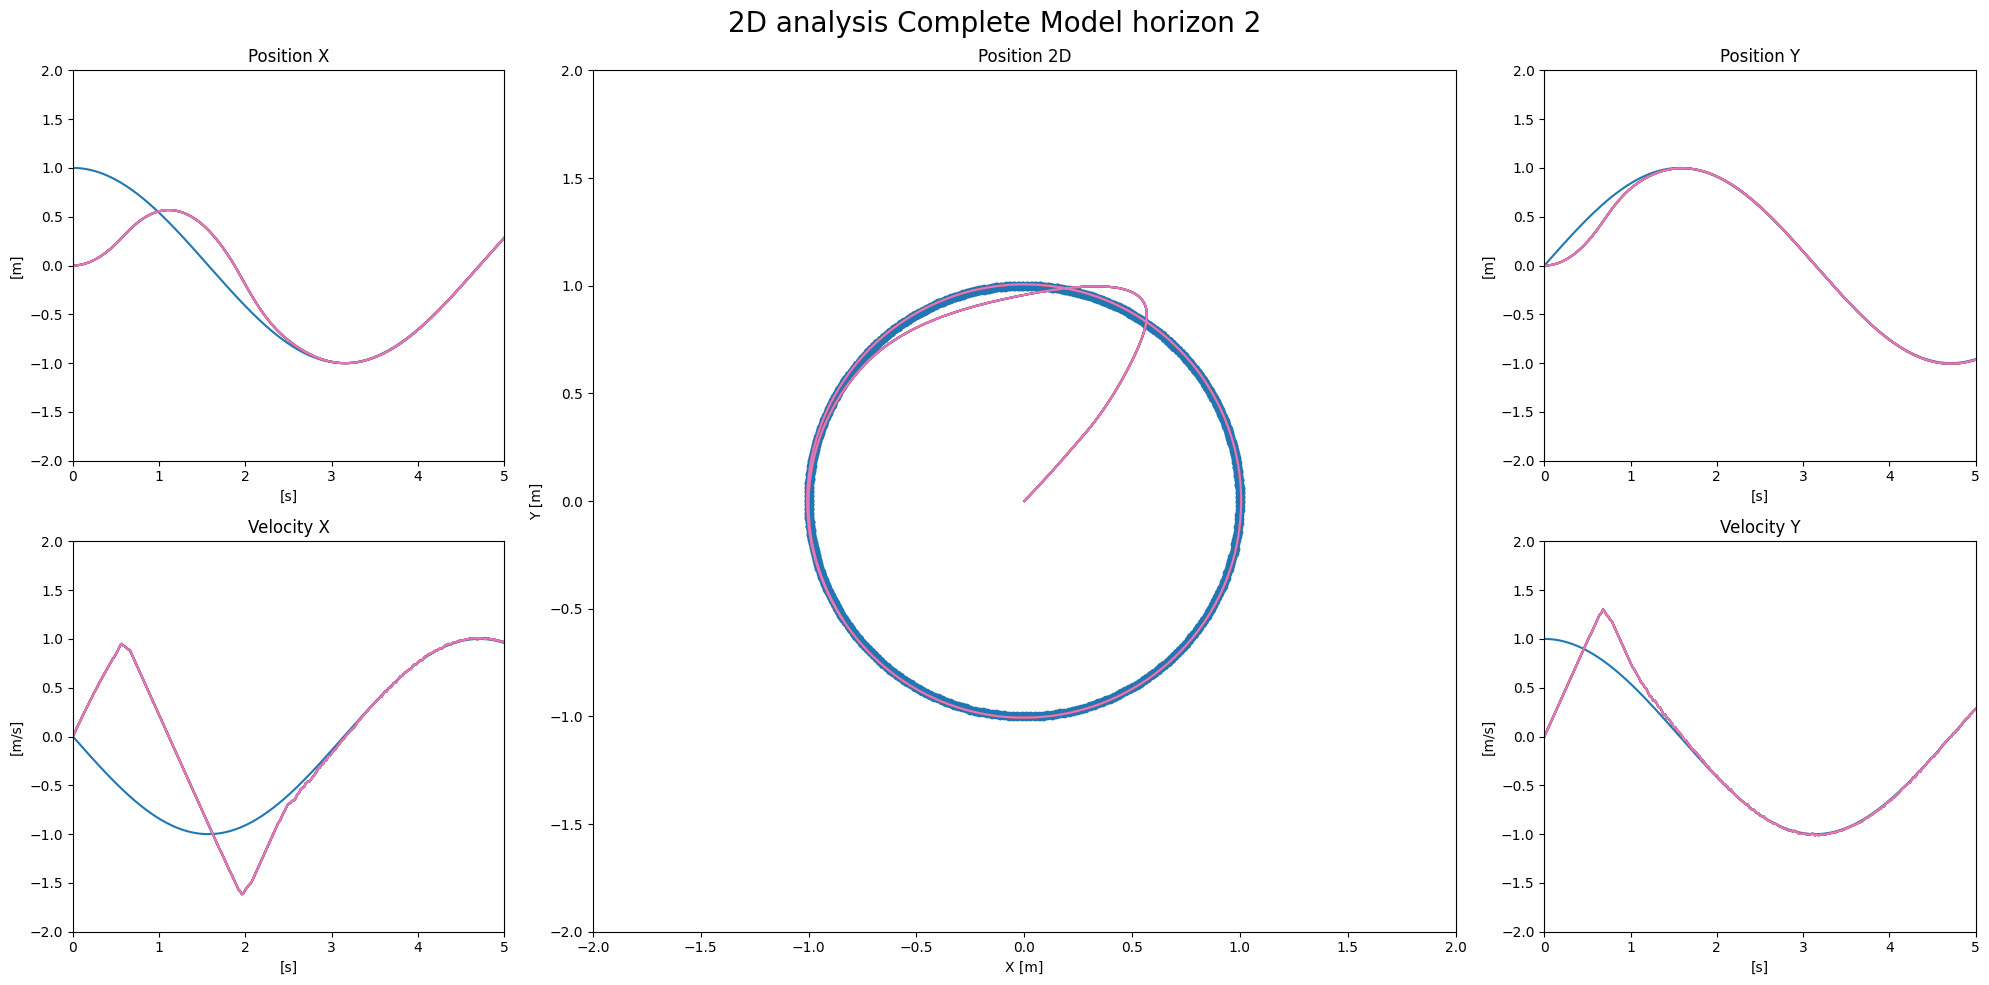

In [ ]:
A = []
L = []
for i in range(2,20,3):
    A.append( read_one_2D(f'Data2d/ElipticCorr/2/2DHorizon{i}Data0.csv'))
    


Create_2D_Graphic("2D analysis Complete Model horizon 2", A, 5)

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\3649632475.py:147: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  X = plt.subplot(gs[0, 0])


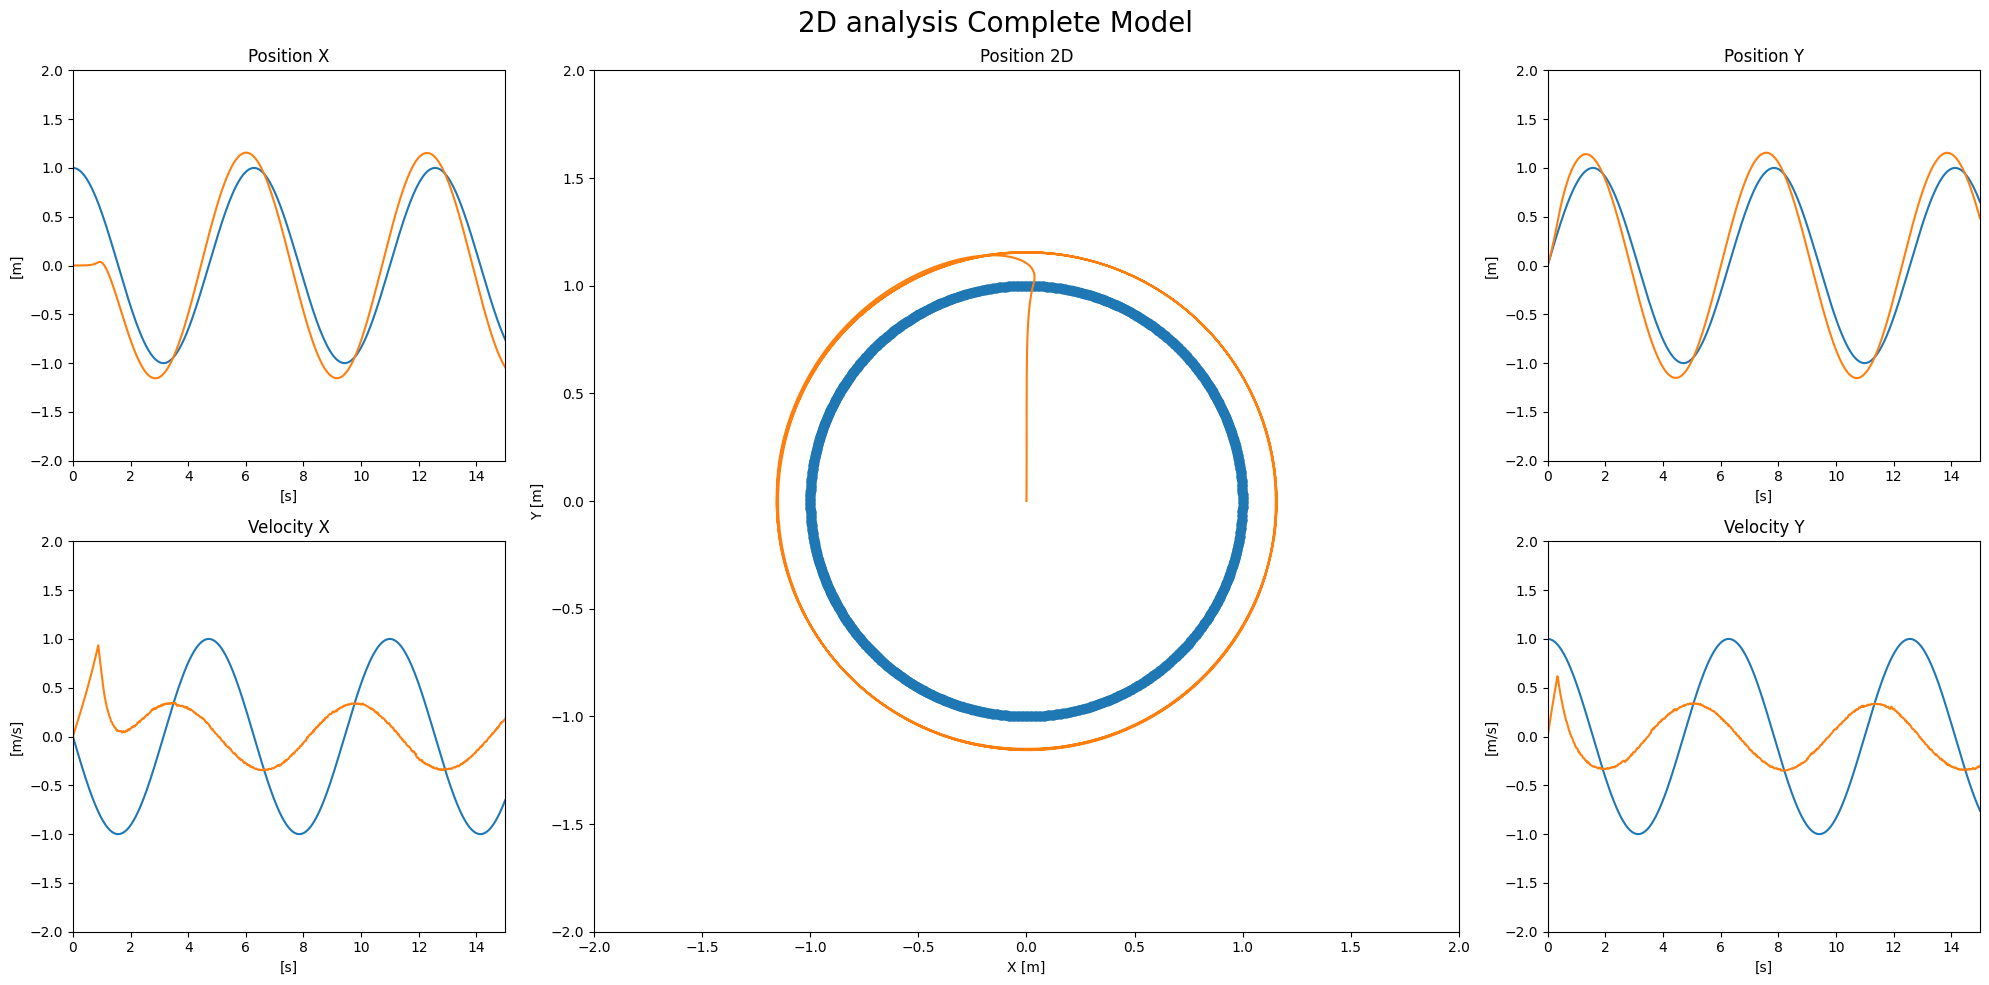

In [ ]:
A = []
L = []
A.append( read_one2D(f'2DelpticData0.csv'))
Create_2D_Graphic("2D analysis Complete Model", A)


C:\Users\marco\AppData\Local\Temp\ipykernel_10432\3649632475.py:147: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  X = plt.subplot(gs[0, 0])


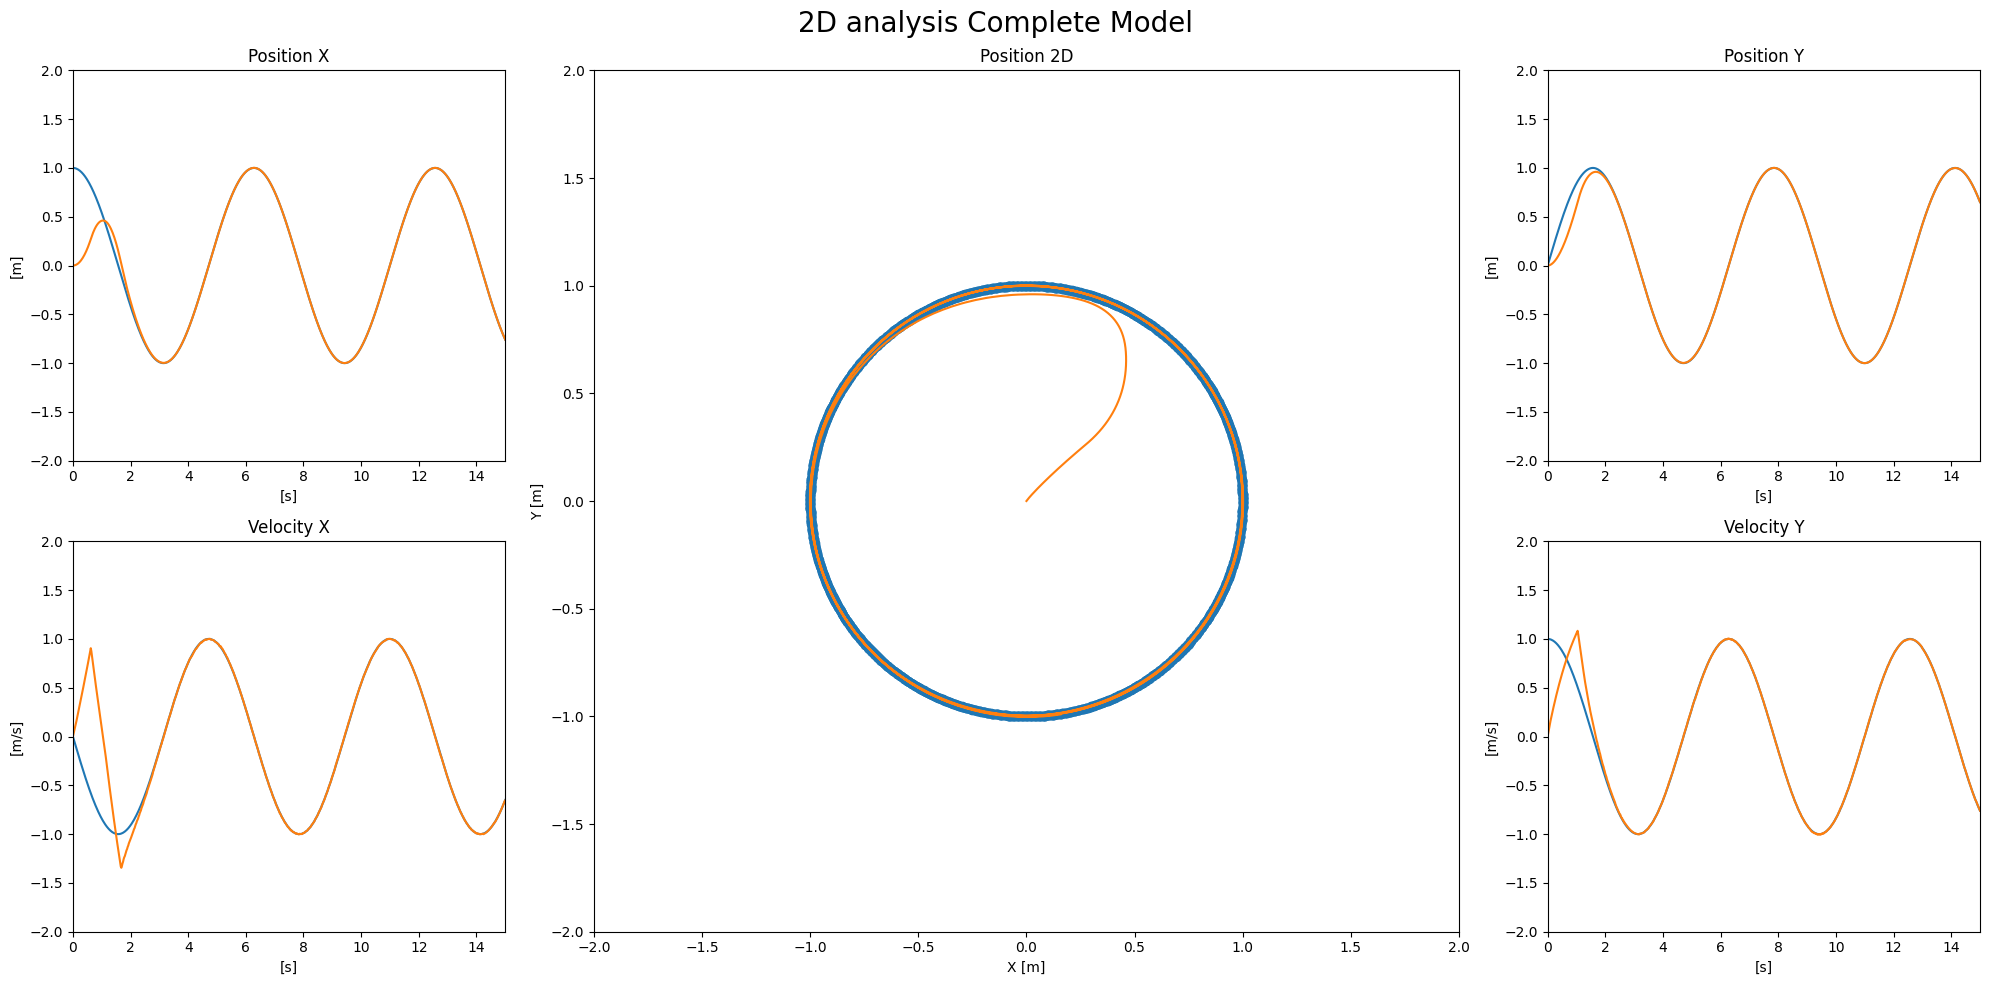

In [ ]:
A = []
L = []
A.append( read_one2D(f'2Delptic2Data0.csv'))
Create_2D_Graphic("2D analysis Complete Model", A)

C:\Users\marco\AppData\Local\Temp\ipykernel_10432\3649632475.py:147: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  X = plt.subplot(gs[0, 0])


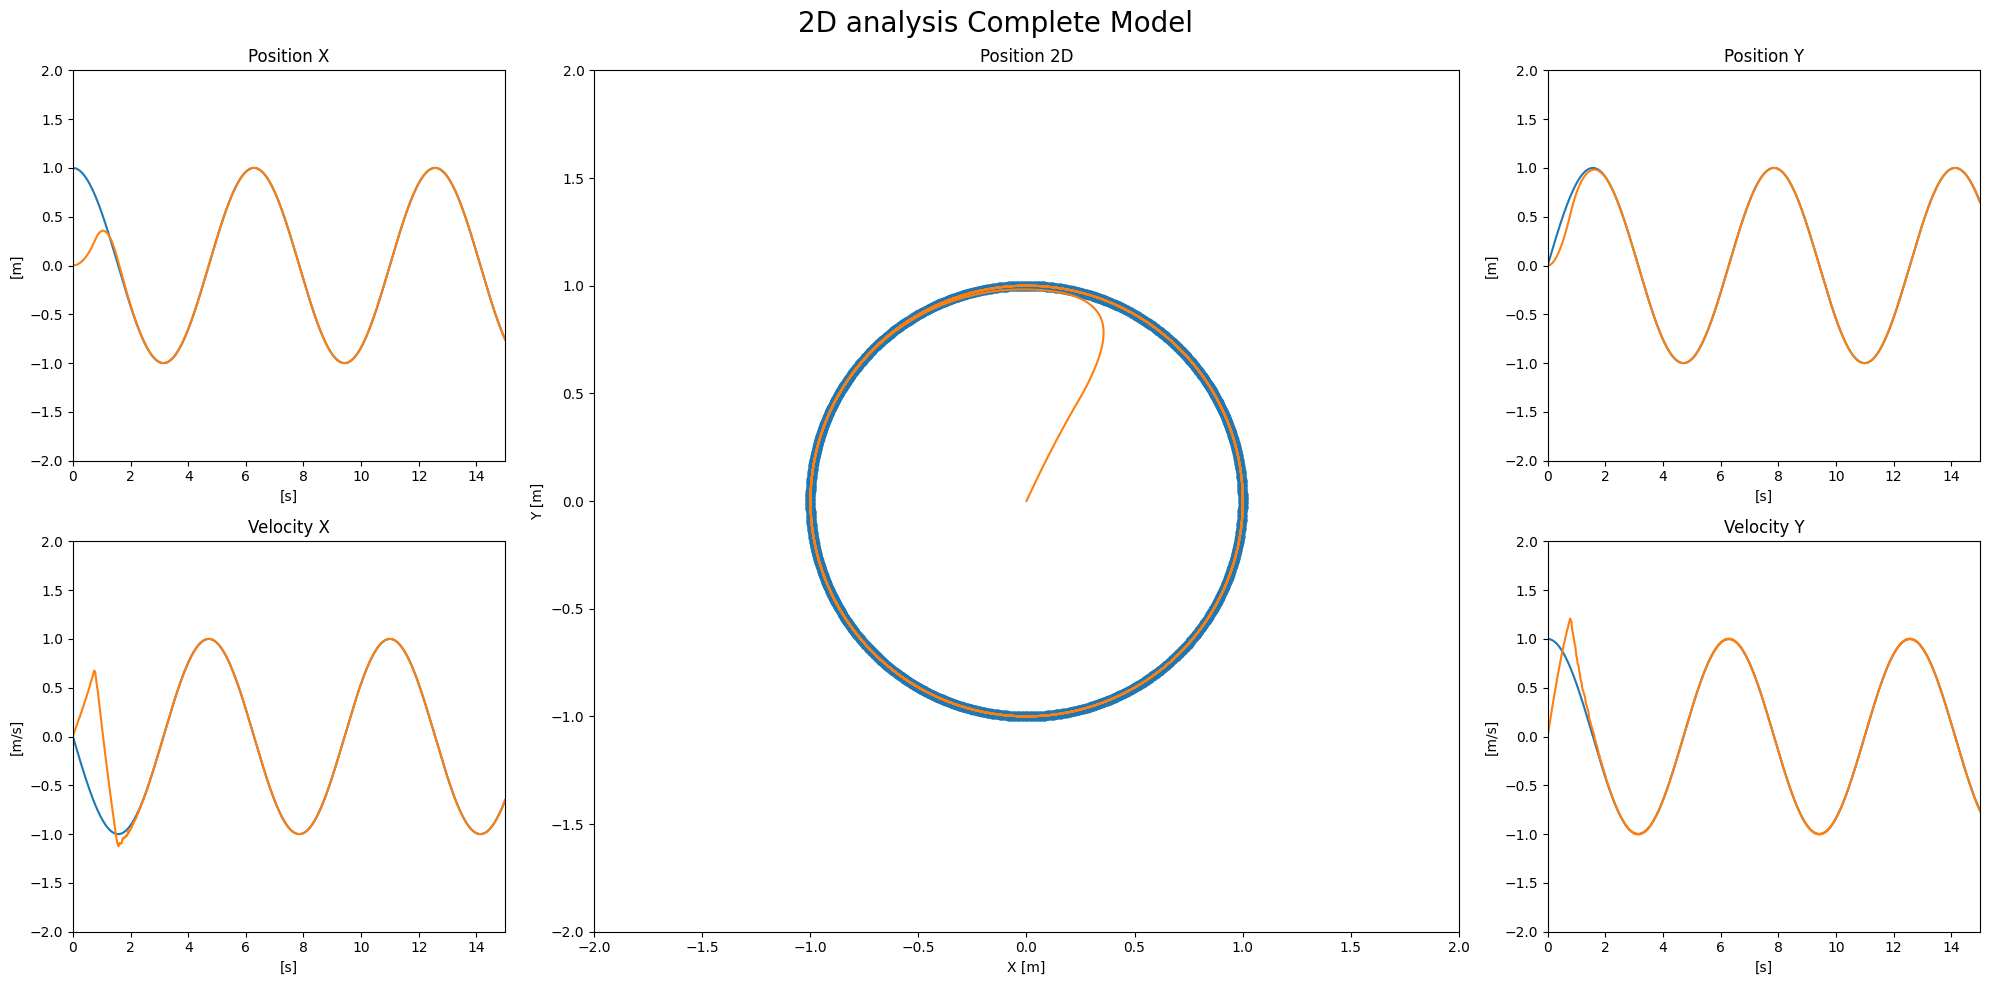

In [ ]:

A = []
L = []
A.append( read_one2D(f'2DelpticAc20D003Data0.csv'))
Create_2D_Graphic("2D analysis Complete Model", A)

In [ ]:

def create_animation():
    # Dados iniciais dos pontos
    num_pontos = 100
    posicoes_iniciais = np.random.rand(num_pontos, 2)  # Gerando posições aleatórias

    # Dados do ponto na trajetória circular
    raio = 0.3
    theta = np.linspace(0, 2 * np.pi, num_pontos)[:, np.newaxis]
    posicoes_circulares = np.hstack((raio * np.cos(theta), raio * np.sin(theta)))

    # Criando a figura e o eixo
    fig, ax = plt.subplots()

    # Lista para armazenar os quadros da animação
    quadros = []

    # Lista para armazenar as posições anteriores do ponto circular
    rastro_posicoes_circulares = []

    # Função para atualizar a posição dos pontos a cada quadro da animação
    def atualizar_quadro(frame):
        global posicoes_iniciais

        # Movendo os pontos aleatoriamente
        posicoes_iniciais += np.random.rand(num_pontos, 2) * 0.1

        # Limpando o eixo
        ax.clear()

        # Plotando os pontos atualizados
        ax.scatter(posicoes_iniciais[:, 0], posicoes_iniciais[:, 1])

        # Plotando o ponto na trajetória circular
        ponto_circular = posicoes_circulares[frame % num_pontos]
        ax.scatter(ponto_circular[0], ponto_circular[1], color='red')

        # Adicionando a posição atual do ponto circular ao rastro
        rastro_posicoes_circulares.append(ponto_circular)

        # Plotando o rastro das posições anteriores do ponto circular
        rastro = np.array(rastro_posicoes_circulares)
        ax.plot(rastro[:, 0], rastro[:, 1], 'gray', alpha=0.3)

        # Definindo limites do eixo para manter os pontos visíveis
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        
        
        ax.set_title("2D Analysis")
        ax.text(0.6, 0.7, f'Quadro: {frame}', transform=ax.transAxes, fontsize=12)

        # Salvando o quadro como imagem
        fig.canvas.draw()
        imagem = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        imagem = imagem.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        quadros.append(Image.fromarray(imagem))

    # Criando a animação
    animacao = FuncAnimation(fig, atualizar_quadro, frames=200, interval=50)

    # Salvando a animação como um arquivo GIF
    animacao.save('animacao2.gif', writer='pillow', fps=30)

    # Exibindo a animação
    plt.show()

In [ ]:

def create_animation(Data,Title, Subtitle, name):
    # Dados iniciais dos pontos
    
    # Criando a figura e o eixo
    fig, ax = plt.subplots()

    # Lista para armazenar os quadros da animação
    quadros = []

     # Gerando cores aleatórias para cada curva
    cores = [(random.random(), random.random(), random.random()) for _ in range(len(Data))]

    # Função para atualizar a posição dos pontos a cada quadro da animação
    def atualizar_quadro(frame):
        nonlocal Data, cores
        # Limpando o eixo
        ax.clear()
        posicao_x = Data[0][4][:frame+1]
        posicao_y = Data[0][6][:frame+1]
        t = Data[0][8][:frame+1]
        # ax.plot(posicao_x, posicao_y, color='blue', alpha=1)
        ax.text(0.02, 0.95, f'Tempo: {t[-1]} s', transform=ax.transAxes, verticalalignment='top')

            # Plotando o ponto atual
        ax.scatter(posicao_x[-1], posicao_y[-1],marker='o', color = 'blue', label = 'Goal')
        
        
        # Atualizando os pontos no gráfico
        for sub, posicao, c in zip(Subtitle,Data, cores):
            posicao_x = posicao[0][:frame+1]
            posicao_y = posicao[2][:frame+1]
            
            # Plotando o rastro do ponto
            ax.plot(posicao_x, posicao_y, color = c, alpha=0.3)

            # Plotando o ponto atual
            ax.scatter(posicao_x[-1], posicao_y[-1], marker='3',color = c, s = 100, label = sub)
            

        # Definindo limites do eixo para manter os pontos visíveis
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")
        # Adicionando título
        ax.set_title(Title)
        
    
        ax.legend()

        # Salvando o quadro como imagem
        fig.canvas.draw()
        imagem = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        imagem = imagem.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        quadros.append(Image.fromarray(imagem))

# Função para adicionar uma nova posição ao conjunto de dados
    def adicionar_posicao(posicao):
        global Data
        Data.append(posicao)


    # Criando a animação
    animacao = FuncAnimation(fig, atualizar_quadro, frames=len(Data[0][1]), interval=20)

    # Salvando a animação como um arquivo GIF
    animacao.save(f'{name}.gif', writer='pillow', fps=30)

    # Exibindo a animação
    plt.show()

In [ ]:
A = []
L = []
L.append("teste")
A.append( read_one_2D(f'2DelpticH2Data0.csv'))
create_animation(A,'2D anlysis' , L, 'Teste')

FileNotFoundError: [Errno 2] No such file or directory: '2DelpticH2Data0.csv'